In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/parkinsons-disease-dataset-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'parkinsons-disease-dataset-analysis' dataset.
Path to dataset files: /kaggle/input/parkinsons-disease-dataset-analysis


In [92]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [93]:
pip install xgboost

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import PowerTransformer
from scipy.stats import norm, skew, ttest_ind, f_oneway

from sklearn.decomposition import PCA
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [57]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/parkinsons-disease-dataset-analysis/parkinsons_disease_data.csv


In [58]:
dataset = pd.read_csv('/kaggle/input/parkinsons-disease-dataset-analysis/parkinsons_disease_data.csv')

In [59]:
dataset.head()

PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       3058   85       0          3               1  19.619878        0   
1       3059   75       0          0               2  16.247339        1   
2       3060   70       1          0               0  15.368239        0   
3       3061   52       0          0               0  15.454557        0   
4       3062   87       0          0               1  18.616042        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  \
0            5.108241          1.380660     3.893969  ...   
1            6.027648          8.409804     8.513428  ...   
2            2.242135          0.213275     6.498805  ...   
3            5.997788          1.375045     6.715033  ...   
4            9.775243          1.188607     4.657572  ...   

   FunctionalAssessment  Tremor  Rigidity  Bradykinesia  PosturalInstability  \
0              1.572427       1         0             0                    0   
1              4.787551       0         1             0                    1   
2              2.130686       1         0             0                    0   
3              3.391288       1         1             1                    0   
4              3.200969       0         0             0                    1   

   SpeechProblems  SleepDisorders  Constipation  Diagnosis  DoctorInCharge  
0               0               0             0          0     DrXXXConfid  
1               0               1             0          1     DrXXXConfid  
2               1               0             1          1     DrXXXConfid  
3               0               0             1          1     DrXXXConfid  
4               0               1             0          0     DrXXXConfid  

[5 rows x 35 columns]

In [60]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PatientID                 2105 non-null   int64  
 1   Age                       2105 non-null   int64  
 2   Gender                    2105 non-null   int64  
 3   Ethnicity                 2105 non-null   int64  
 4   EducationLevel            2105 non-null   int64  
 5   BMI                       2105 non-null   float64
 6   Smoking                   2105 non-null   int64  
 7   AlcoholConsumption        2105 non-null   float64
 8   PhysicalActivity          2105 non-null   float64
 9   DietQuality               2105 non-null   float64
 10  SleepQuality              2105 non-null   float64
 11  FamilyHistoryParkinsons   2105 non-null   int64  
 12  TraumaticBrainInjury      2105 non-null   int64  
 13  Hypertension              2105 non-null   int64  
 14  Diabetes

In [61]:
dataset.describe()

PatientID          Age       Gender    Ethnicity  EducationLevel  \
count  2105.000000  2105.000000  2105.000000  2105.000000     2105.000000   
mean   4110.000000    69.601900     0.492637     0.692637        1.337292   
std     607.805479    11.594511     0.500065     1.003827        0.895840   
min    3058.000000    50.000000     0.000000     0.000000        0.000000   
25%    3584.000000    60.000000     0.000000     0.000000        1.000000   
50%    4110.000000    70.000000     0.000000     0.000000        1.000000   
75%    4636.000000    80.000000     1.000000     1.000000        2.000000   
max    5162.000000    89.000000     1.000000     3.000000        3.000000   

               BMI      Smoking  AlcoholConsumption  PhysicalActivity  \
count  2105.000000  2105.000000         2105.000000       2105.000000   
mean     27.209493     0.296437           10.040413          5.016674   
std       7.208099     0.456795            5.687014          2.890919   
min      15.008333     0.000000            0.002228          0.004157   
25%      20.782176     0.000000            5.150278          2.455703   
50%      27.184571     0.000000           10.070337          5.031550   
75%      33.462452     1.000000           14.829565          7.512795   
max      39.999887     1.000000           19.988866          9.995255   

       DietQuality  ...         MoCA  FunctionalAssessment       Tremor  \
count  2105.000000  ...  2105.000000           2105.000000  2105.000000   
mean      4.912901  ...    15.094314              4.989694     0.431829   
std       2.872115  ...     8.643014              2.933877     0.495449   
min       0.000011  ...     0.021191              0.001505     0.000000   
25%       2.478503  ...     7.517160              2.415890     0.000000   
50%       4.825187  ...    14.963574              4.983227     0.000000   
75%       7.381487  ...    22.608362              7.484220     1.000000   
max       9.995864  ...    29.970107              9.992697     1.000000   

          Rigidity  Bradykinesia  PosturalInstability  SpeechProblems  \
count  2105.000000   2105.000000          2105.000000     2105.000000   
mean      0.252732      0.207601             0.138717        0.295012   
std       0.434682      0.405686             0.345733        0.456156   
min       0.000000      0.000000             0.000000        0.000000   
25%       0.000000      0.000000             0.000000        0.000000   
50%       0.000000      0.000000             0.000000        0.000000   
75%       1.000000      0.000000             0.000000        1.000000   
max       1.000000      1.000000             1.000000        1.000000   

       SleepDisorders  Constipation    Diagnosis  
count     2105.000000   2105.000000  2105.000000  
mean         0.245131      0.296912     0.619477  
std          0.430267      0.457006     0.485631  
min          0.000000      0.000000     0.000000  
25%          0.000000      0.000000     0.000000  
50%          0.000000      0.000000     1.000000  
75%          0.000000      1.000000     1.000000  
max          1.000000      1.000000     1.000000  

[8 rows x 34 columns]

In [62]:
dataset['Smoking'].describe()

count    2105.000000
mean        0.296437
std         0.456795
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Smoking, dtype: float64

In [63]:
dataset.isnull().sum()

PatientID                   0
Age                         0
Gender                      0
Ethnicity                   0
EducationLevel              0
BMI                         0
Smoking                     0
AlcoholConsumption          0
PhysicalActivity            0
DietQuality                 0
SleepQuality                0
FamilyHistoryParkinsons     0
TraumaticBrainInjury        0
Hypertension                0
Diabetes                    0
Depression                  0
Stroke                      0
SystolicBP                  0
DiastolicBP                 0
CholesterolTotal            0
CholesterolLDL              0
CholesterolHDL              0
CholesterolTriglycerides    0
UPDRS                       0
MoCA                        0
FunctionalAssessment        0
Tremor                      0
Rigidity                    0
Bradykinesia                0
PosturalInstability         0
SpeechProblems              0
SleepDisorders              0
Constipation                0
Diagnosis                   0
DoctorInCharge              0
dtype: int64

In [64]:
dataset.duplicated().any()

np.False_

In [65]:
dataset['Diagnosis'].value_counts()

Diagnosis
1    1304
0     801
Name: count, dtype: int64

In [66]:
dataset.drop(columns=["PatientID", "DoctorInCharge"], inplace=True)

In [67]:
dataset.head()

Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   85       0          3               1  19.619878        0   
1   75       0          0               2  16.247339        1   
2   70       1          0               0  15.368239        0   
3   52       0          0               0  15.454557        0   
4   87       0          0               1  18.616042        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            5.108241          1.380660     3.893969      9.283194  ...   
1            6.027648          8.409804     8.513428      5.602470  ...   
2            2.242135          0.213275     6.498805      9.929824  ...   
3            5.997788          1.375045     6.715033      4.196189  ...   
4            9.775243          1.188607     4.657572      9.363925  ...   

        MoCA  FunctionalAssessment  Tremor  Rigidity  Bradykinesia  \
0  29.181289              1.572427       1         0             0   
1  12.332639              4.787551       0         1             0   
2  29.927783              2.130686       1         0             0   
3  21.304268              3.391288       1         1             1   
4   8.336364              3.200969       0         0             0   

   PosturalInstability  SpeechProblems  SleepDisorders  Constipation  \
0                    0               0               0             0   
1                    1               0               1             0   
2                    0               1               0             1   
3                    0               0               0             1   
4                    1               0               1             0   

   Diagnosis  
0          0  
1          1  
2          1  
3          1  
4          0  

[5 rows x 33 columns]

In [68]:
dataset.describe()

Age       Gender    Ethnicity  EducationLevel          BMI  \
count  2105.000000  2105.000000  2105.000000     2105.000000  2105.000000   
mean     69.601900     0.492637     0.692637        1.337292    27.209493   
std      11.594511     0.500065     1.003827        0.895840     7.208099   
min      50.000000     0.000000     0.000000        0.000000    15.008333   
25%      60.000000     0.000000     0.000000        1.000000    20.782176   
50%      70.000000     0.000000     0.000000        1.000000    27.184571   
75%      80.000000     1.000000     1.000000        2.000000    33.462452   
max      89.000000     1.000000     3.000000        3.000000    39.999887   

           Smoking  AlcoholConsumption  PhysicalActivity  DietQuality  \
count  2105.000000         2105.000000       2105.000000  2105.000000   
mean      0.296437           10.040413          5.016674     4.912901   
std       0.456795            5.687014          2.890919     2.872115   
min       0.000000            0.002228          0.004157     0.000011   
25%       0.000000            5.150278          2.455703     2.478503   
50%       0.000000           10.070337          5.031550     4.825187   
75%       1.000000           14.829565          7.512795     7.381487   
max       1.000000           19.988866          9.995255     9.995864   

       SleepQuality  ...         MoCA  FunctionalAssessment       Tremor  \
count   2105.000000  ...  2105.000000           2105.000000  2105.000000   
mean       6.996639  ...    15.094314              4.989694     0.431829   
std        1.753065  ...     8.643014              2.933877     0.495449   
min        4.000497  ...     0.021191              0.001505     0.000000   
25%        5.488864  ...     7.517160              2.415890     0.000000   
50%        6.929819  ...    14.963574              4.983227     0.000000   
75%        8.558719  ...    22.608362              7.484220     1.000000   
max        9.999821  ...    29.970107              9.992697     1.000000   

          Rigidity  Bradykinesia  PosturalInstability  SpeechProblems  \
count  2105.000000   2105.000000          2105.000000     2105.000000   
mean      0.252732      0.207601             0.138717        0.295012   
std       0.434682      0.405686             0.345733        0.456156   
min       0.000000      0.000000             0.000000        0.000000   
25%       0.000000      0.000000             0.000000        0.000000   
50%       0.000000      0.000000             0.000000        0.000000   
75%       1.000000      0.000000             0.000000        1.000000   
max       1.000000      1.000000             1.000000        1.000000   

       SleepDisorders  Constipation    Diagnosis  
count     2105.000000   2105.000000  2105.000000  
mean         0.245131      0.296912     0.619477  
std          0.430267      0.457006     0.485631  
min          0.000000      0.000000     0.000000  
25%          0.000000      0.000000     0.000000  
50%          0.000000      0.000000     1.000000  
75%          0.000000      1.000000     1.000000  
max          1.000000      1.000000     1.000000  

[8 rows x 33 columns]

In [69]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_columns = [
    'Age', 'BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'UPDRS',
    'MoCA', 'FunctionalAssessment'
]

dataset_normalized = remove_outliers(dataset, numerical_columns)

In [70]:
data_copy = dataset.copy()
data_copy['Gender'] = np.where(data_copy['Gender'] == 1, 'female', 'male')
data_copy['Diagnosis'] = np.where(data_copy['Diagnosis'] == 1, 'Yes', 'No')
data_copy['Smoking'] = np.where(data_copy['Smoking'] == 1, 'Yes', 'No')
data_copy['Ethnicity'] = ['Caucasian' if x == 0 else 'African American' if x == 1 else 'Asian' if x == 2 else 'other' for x in data_copy["Ethnicity"]]
data_copy['EducationLevel'] = ['None' if x == 0 else 'High School' if x == 1 else 'Bachelor' if x == 1 else 'Higher' for x in data_copy['EducationLevel']]
data_copy['FamilyHistoryParkinsons'] = np.where(data_copy['FamilyHistoryParkinsons'] == 1, 'Yes', 'No')
data_copy['TraumaticBrainInjury'] = np.where(data_copy['TraumaticBrainInjury'] == 1, 'Yes', 'No')
data_copy['Hypertension'] = np.where(data_copy['Hypertension'] == 1, 'Yes', 'No')
data_copy['Diabetes'] = np.where(data_copy['Diabetes'] == 1, 'Yes', 'No')
data_copy['Depression'] = np.where(data_copy['Depression'] == 1, 'Yes', 'No')
data_copy['Stroke'] = np.where(data_copy['Stroke'] == 1, 'Yes', 'No')

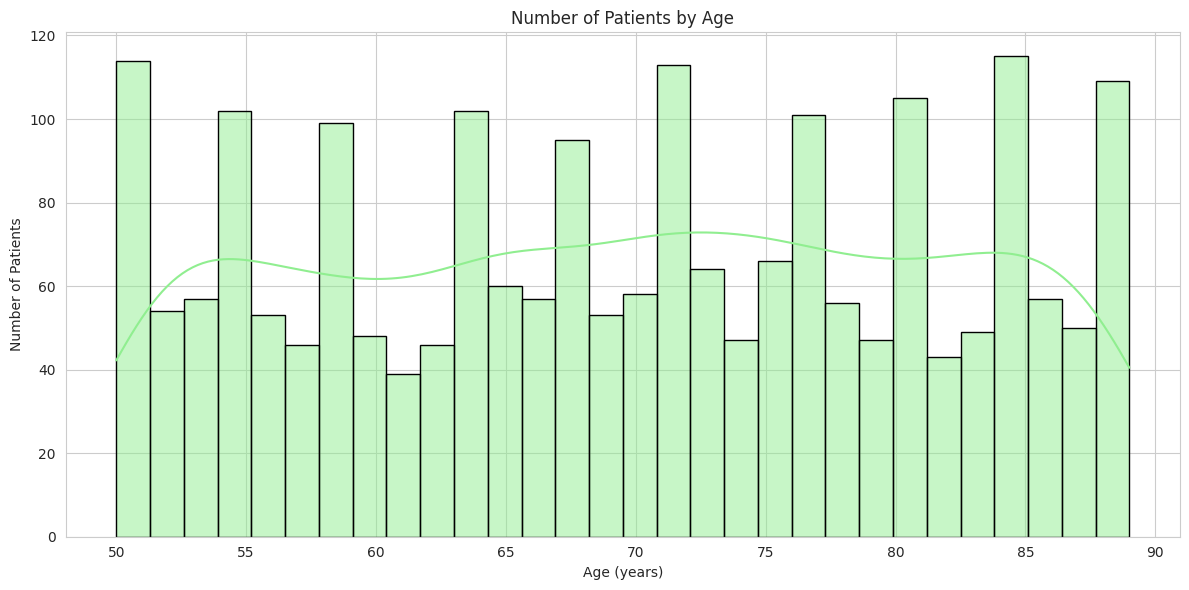

In [71]:
plt.figure(figsize=(12, 6))

# bins = range(min_age, max_age+1) ensures 1 bin for each age
sns.histplot(
    x=data_copy["Age"],
    bins=30,
    kde=True,
    color="lightgreen",
    edgecolor="black"
)

plt.title("Number of Patients by Age")
plt.xlabel("Age (years)")
plt.ylabel("Number of Patients")

# Show every age tick on x-axis
# plt.xticks(dataset["Age"].values)

plt.tight_layout()
plt.show()



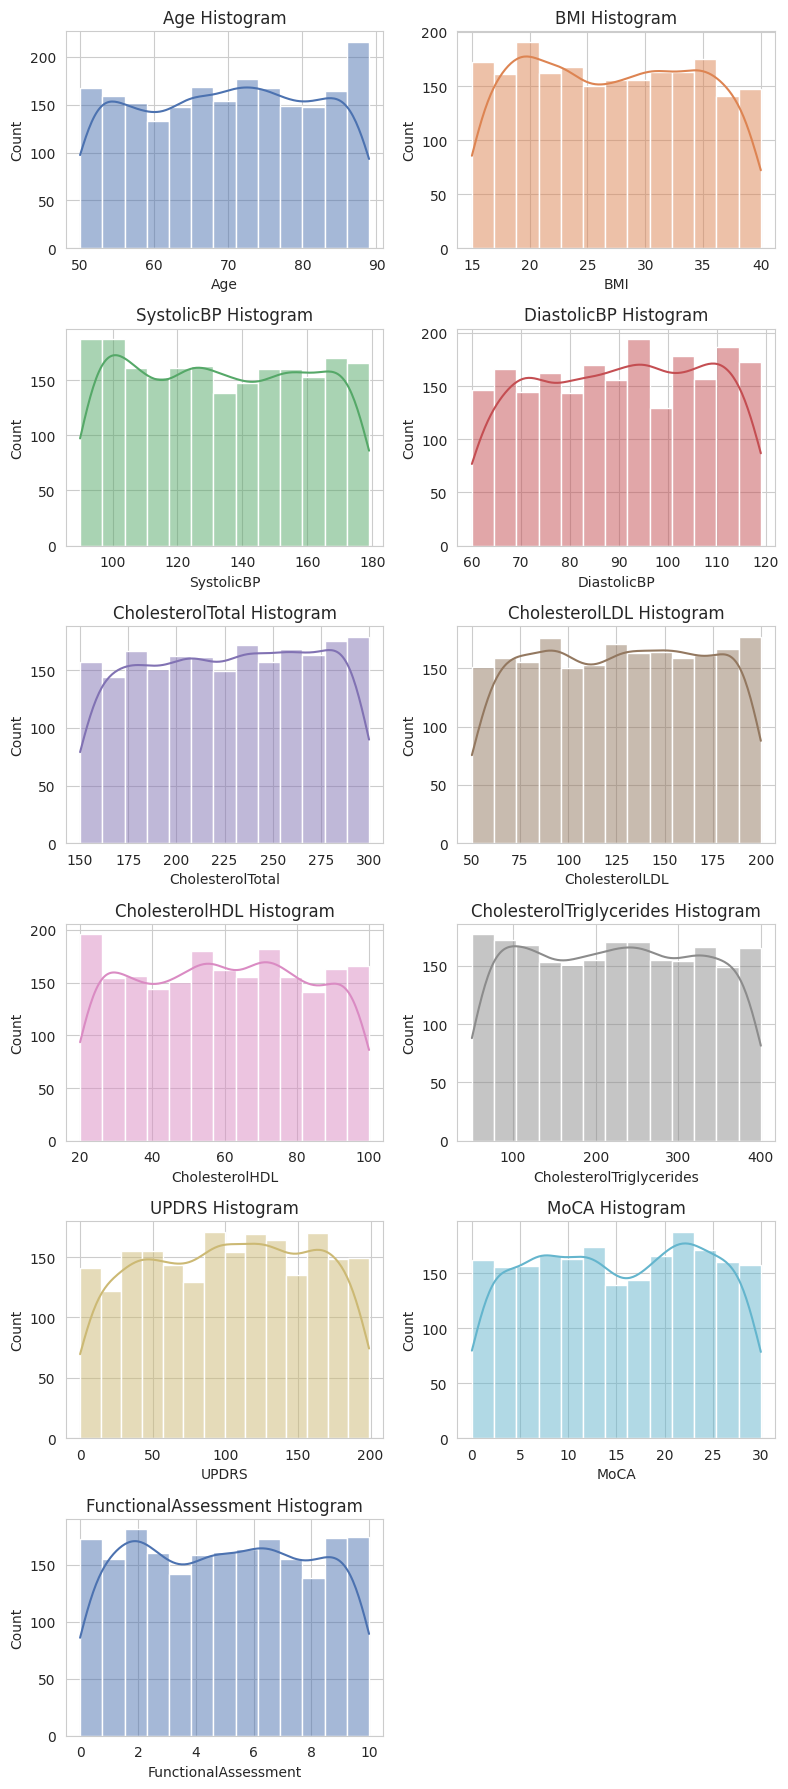

In [72]:
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 3 * n_rows))

axs = axs.flatten()

colors = sns.color_palette("deep", len(numerical_columns))

for i, (col, color) in enumerate(zip(numerical_columns, colors)):
    sns.histplot(data_copy[col], kde=True, ax=axs[i], color=color)
    axs[i].set_title(f'{col} Histogram')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

3 4


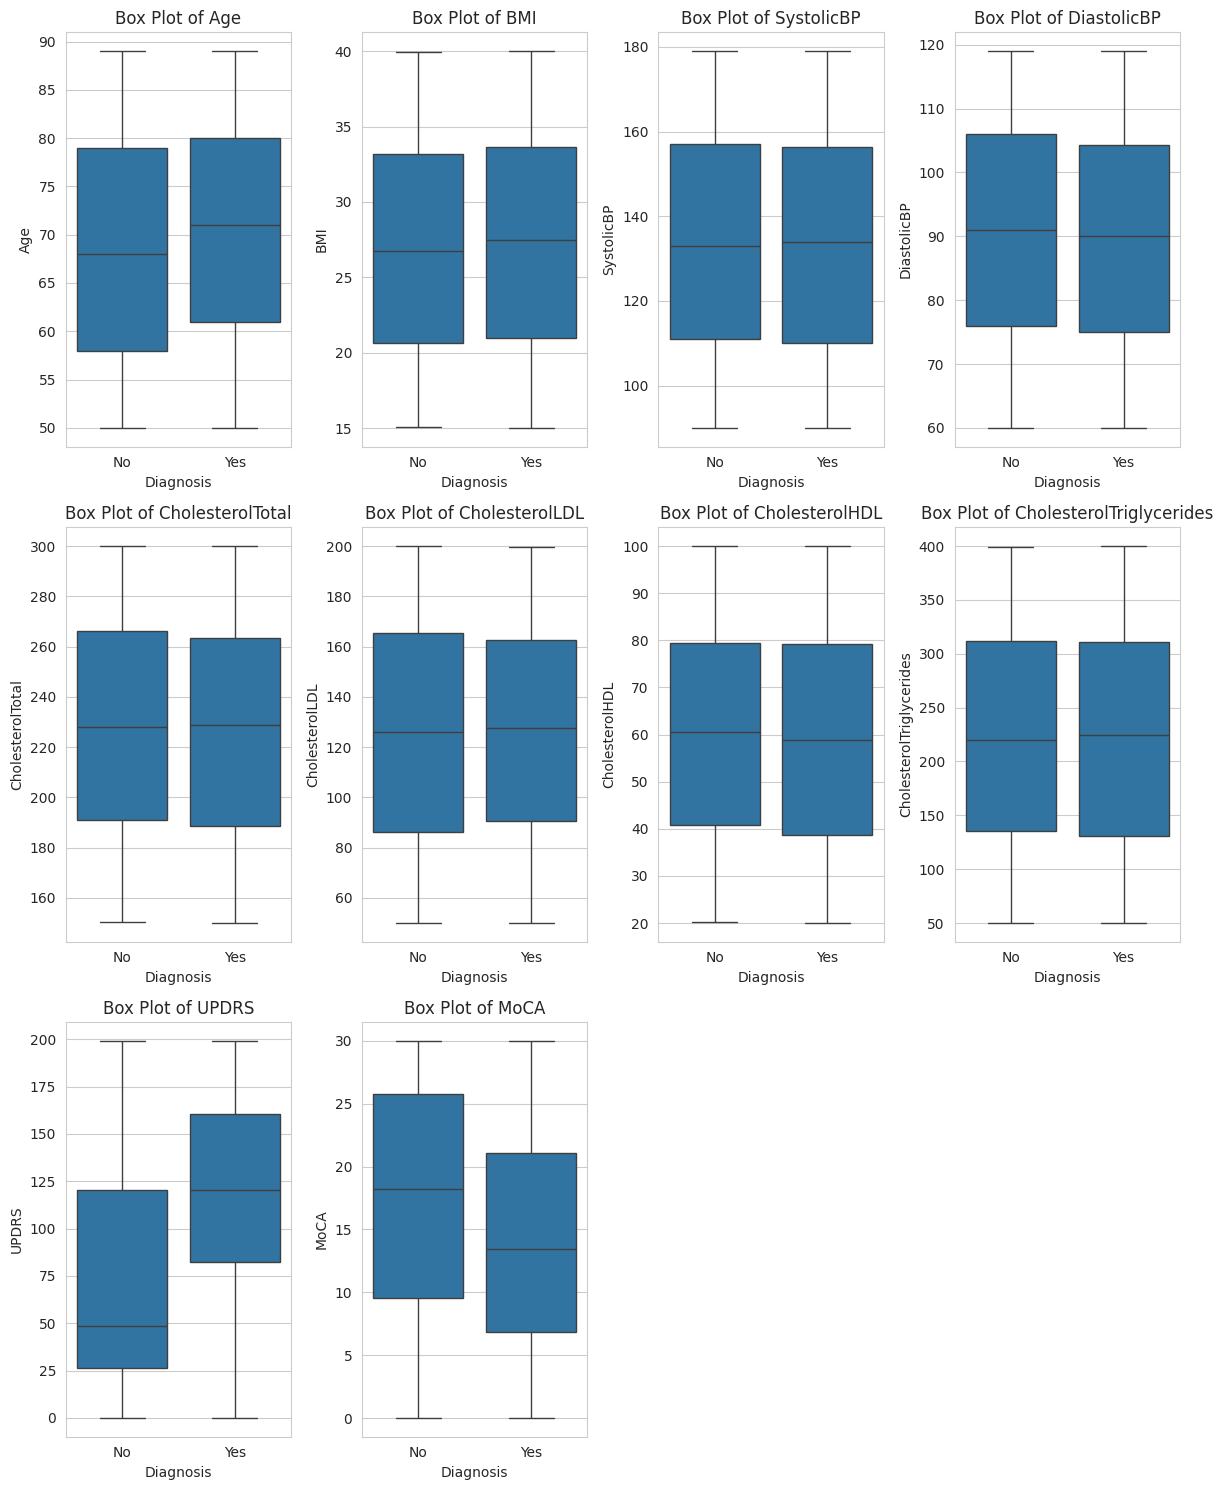

In [73]:
#  Show a box plot of continous variables with and without a parkinsons diagnosis.
plot_columns = 4
plot_rows = math.ceil(len(numerical_columns) / plot_columns)
print(plot_rows, plot_columns)
fig, axs = plt.subplots(plot_rows, plot_columns, figsize = (12,15))
axs = axs.flatten() #  turns the 2D array of axes into a 1D list, which makes iterating through them easier.

for i, col in enumerate(numerical_columns):
    sns.boxplot(x='Diagnosis', y=col, data=data_copy, ax=axs[i])
    axs[i].set_title(f'Box Plot of {col}')
    axs[i].set_ylabel(col)


axs[-2].set_visible(False)
axs[-1].set_visible(False)
plt.tight_layout()
plt.show()

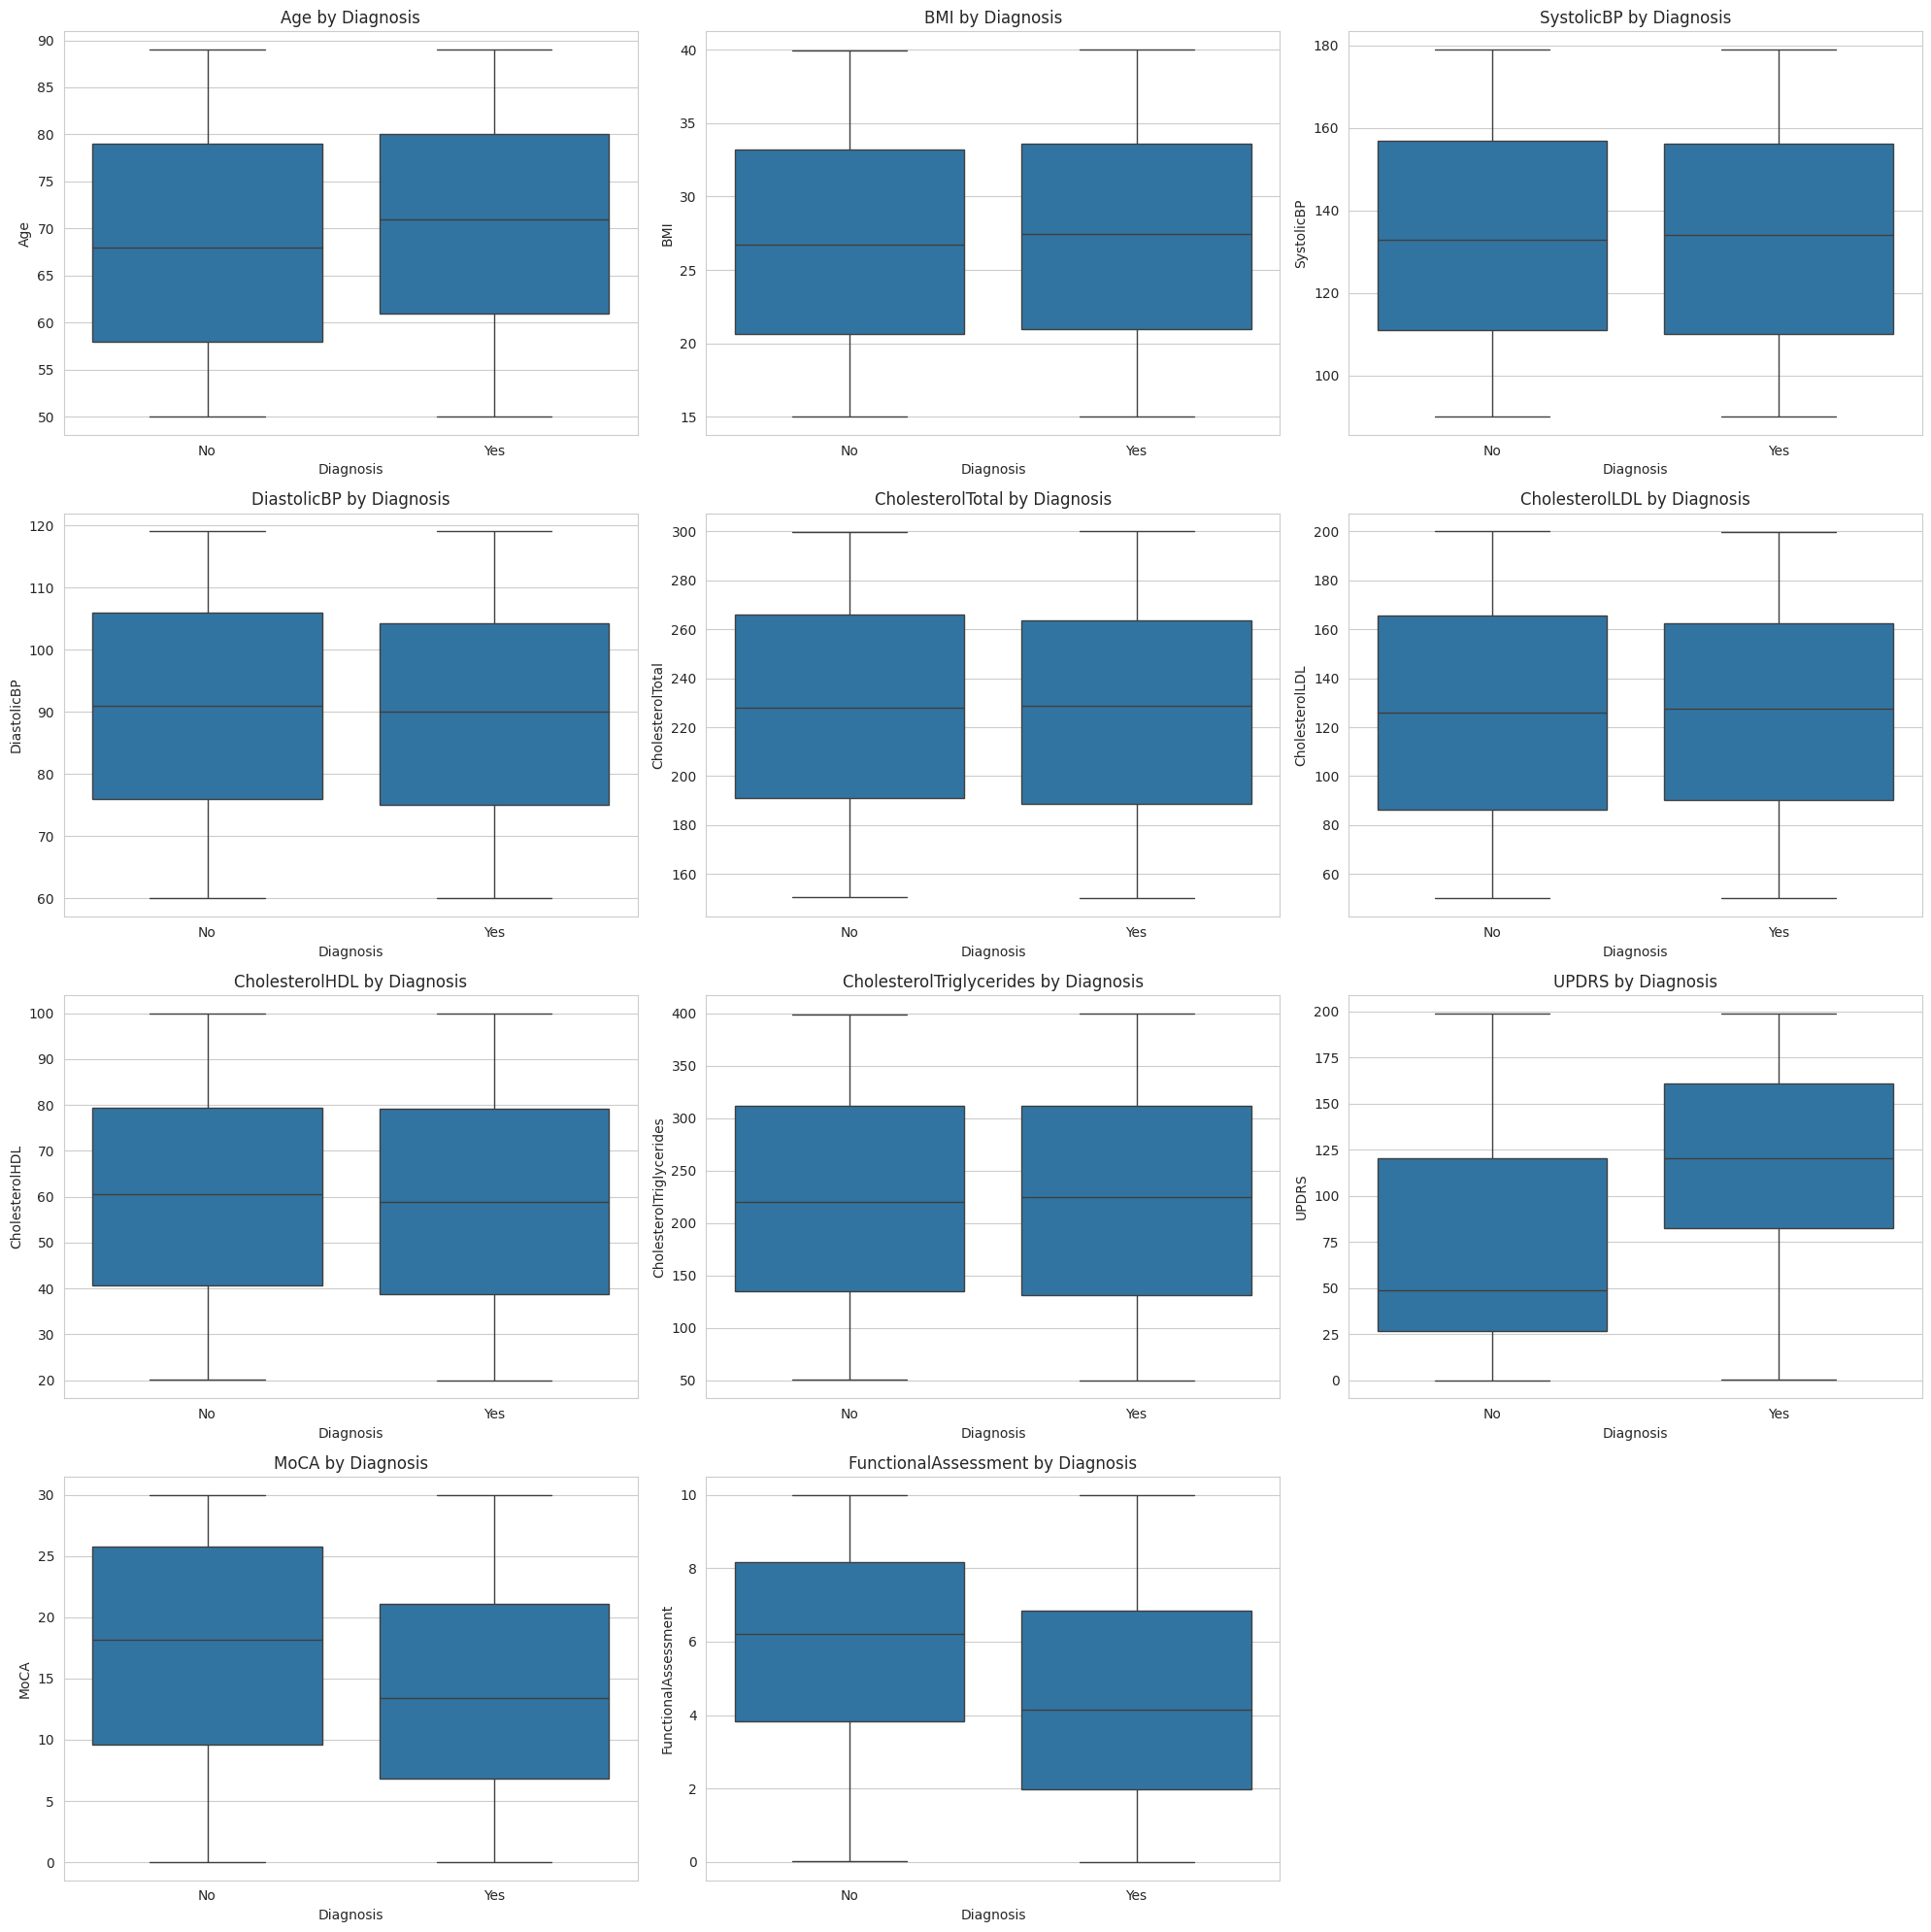

In [74]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x='Diagnosis', y=col, data=data_copy)
    plt.title(f'{col} by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

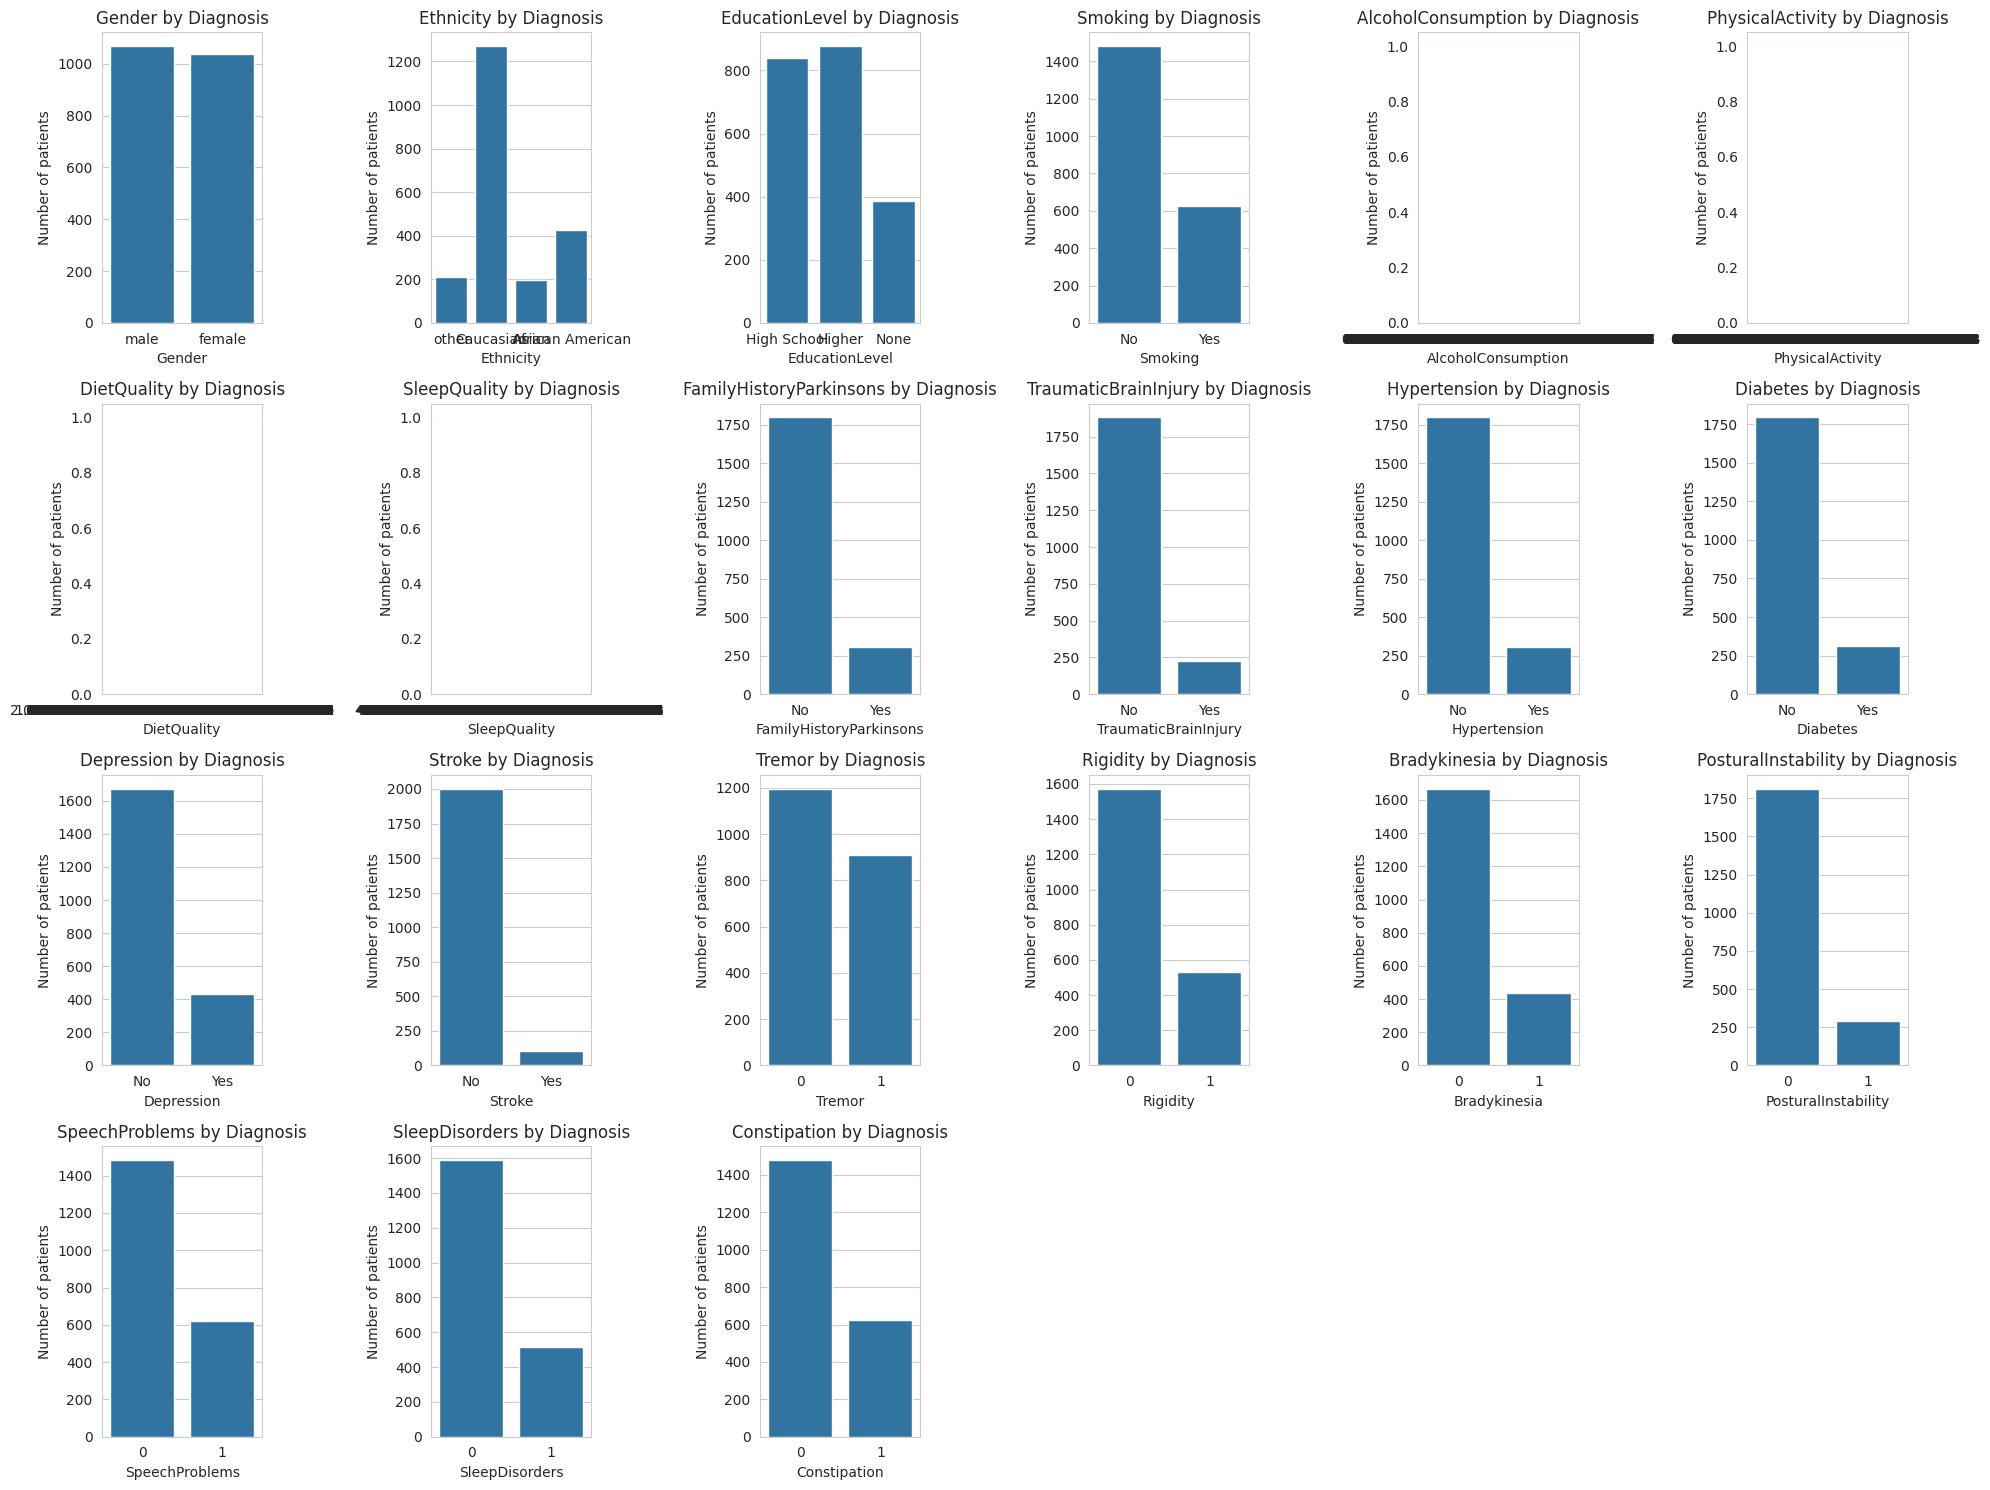

In [75]:
categorical_columns = [
    'Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'AlcoholConsumption',
    'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryParkinsons',
    'TraumaticBrainInjury', 'Hypertension', 'Diabetes', 'Depression', 'Stroke',
    'Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 'SpeechProblems',
    'SleepDisorders', 'Constipation']

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_columns):
  plt.subplot(4, 6, i + 1)
  sns.countplot(x = col, data=data_copy)
  plt.title(f'{col} by Diagnosis')
  plt.xlabel(col)
  plt.ylabel("Number of patients")
plt.tight_layout()
plt.show()

<Axes: xlabel='Diagnosis', ylabel='count'>

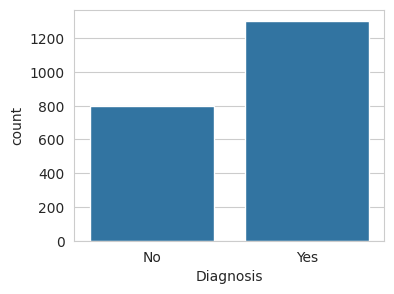

In [76]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x = 'Diagnosis', data = data_copy)

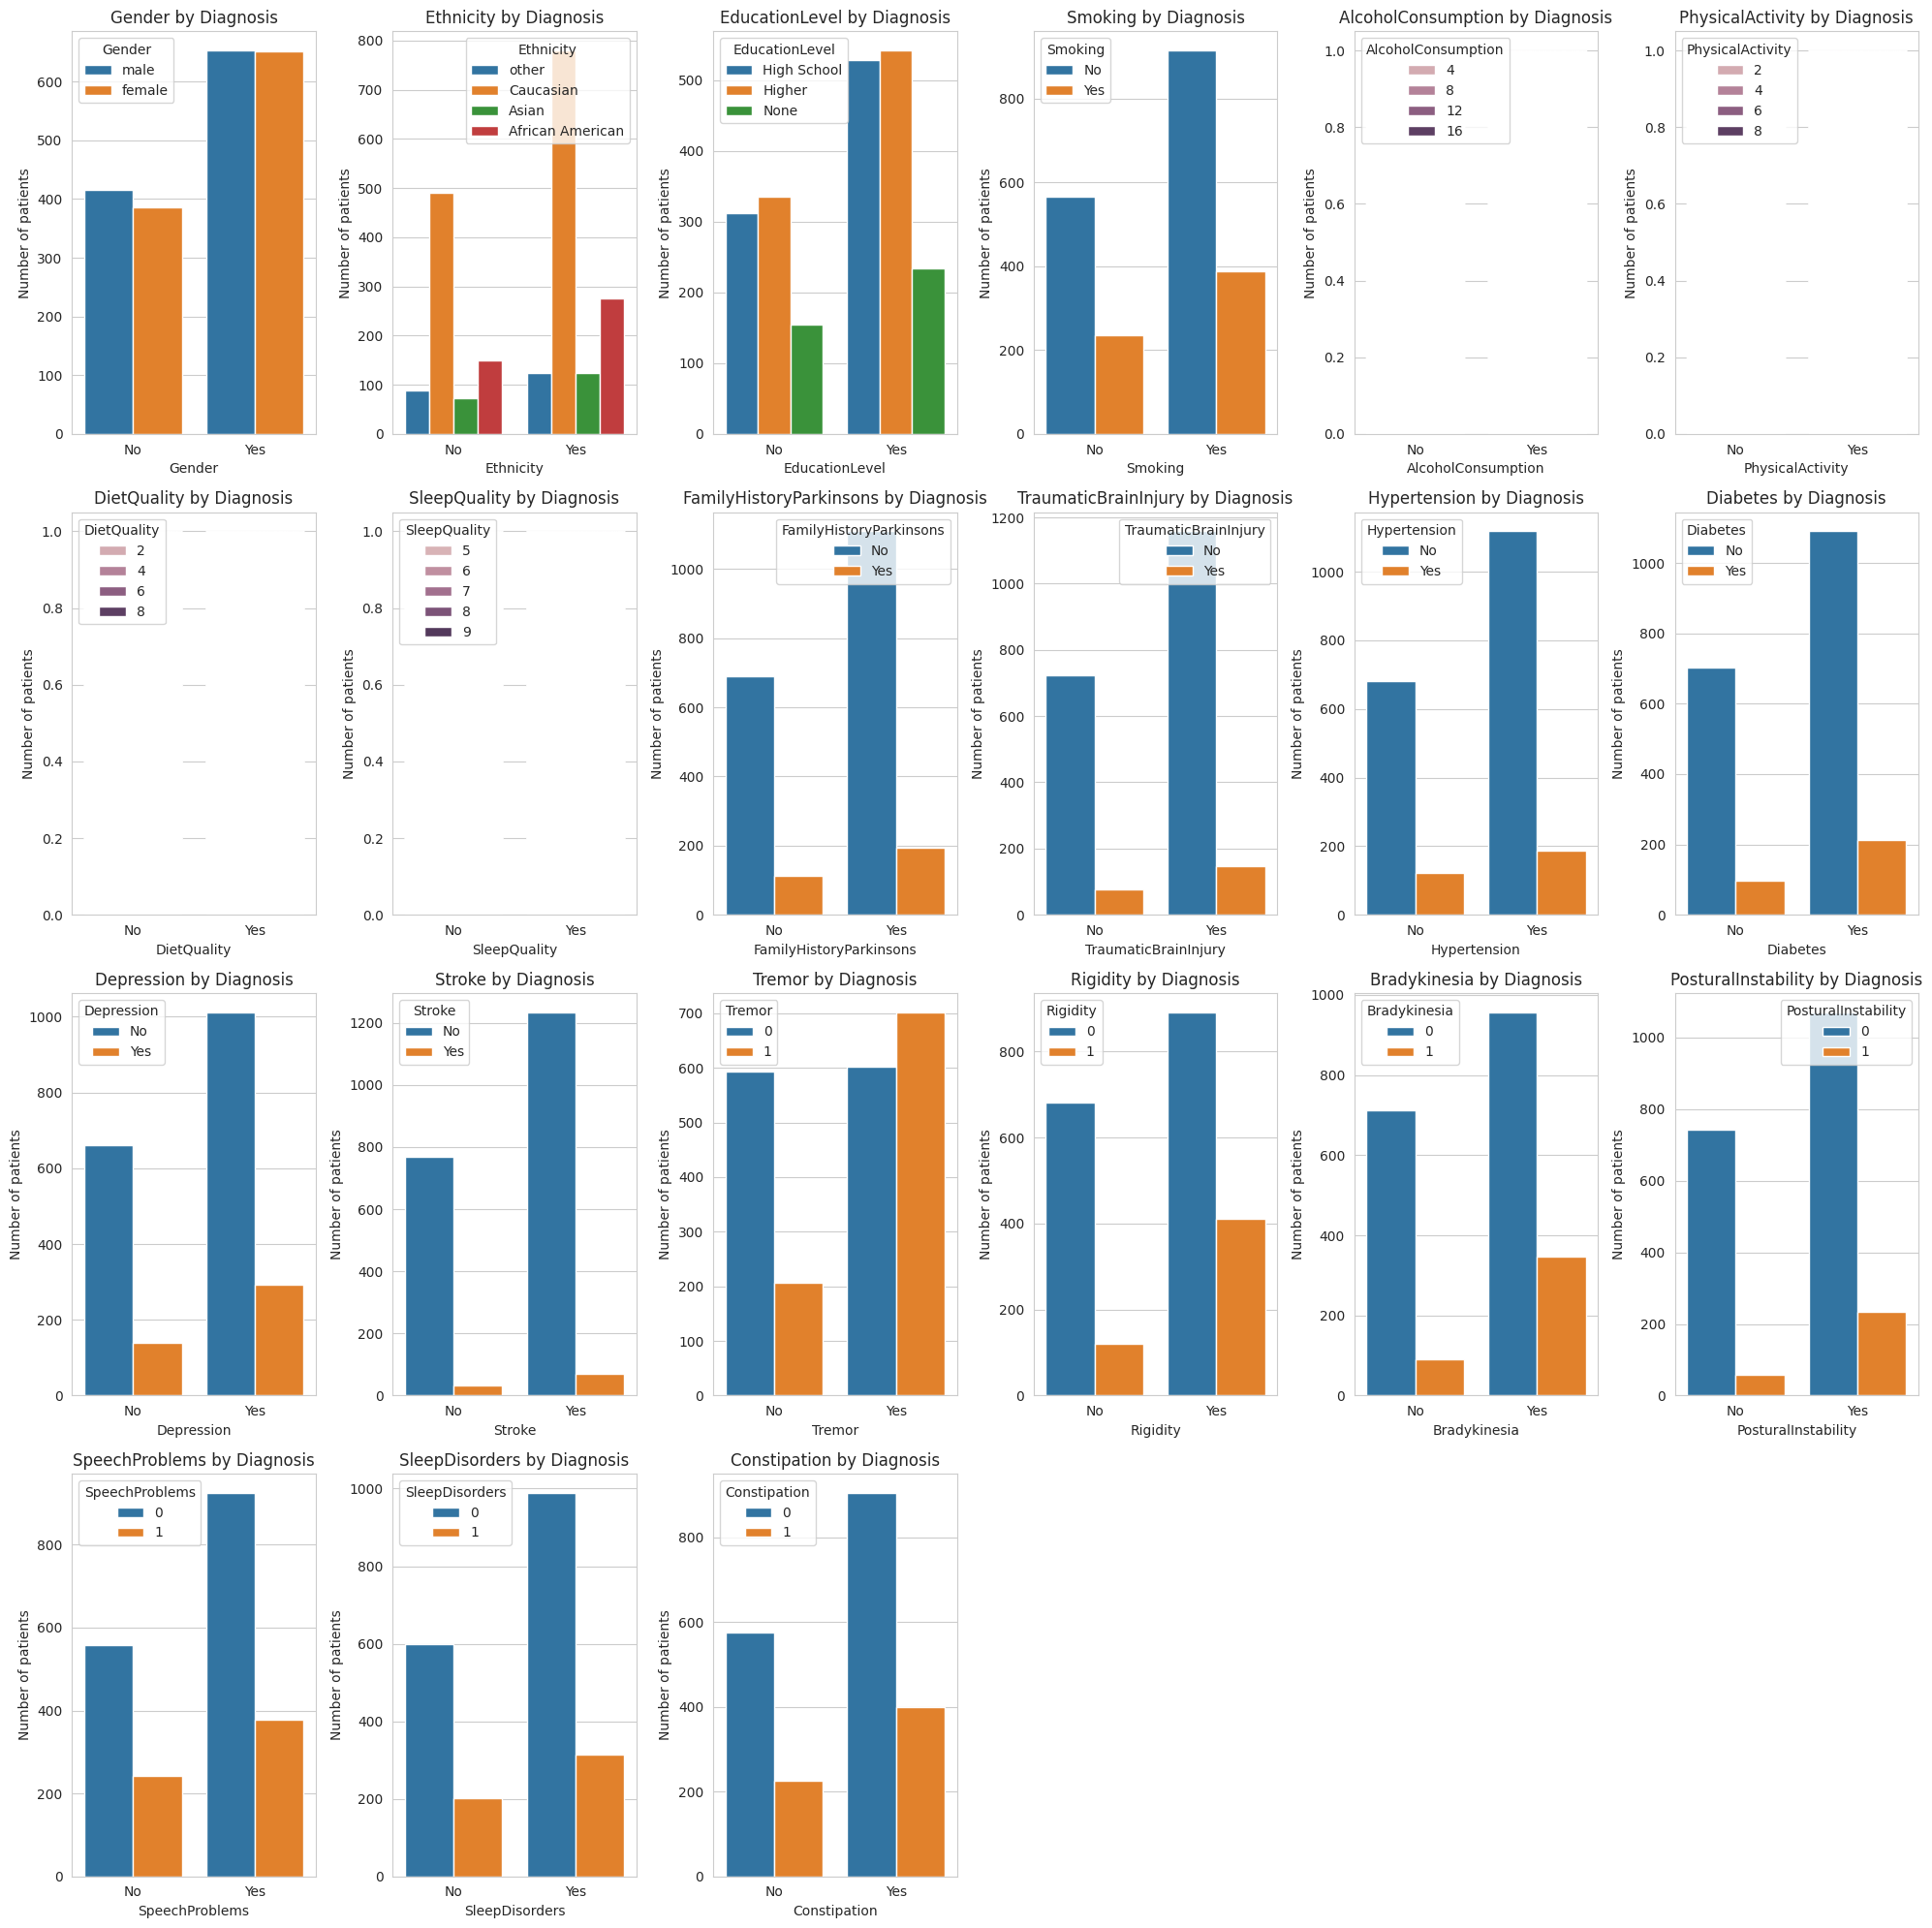

In [77]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(categorical_columns):
  plt.subplot(4, 6, i + 1)
  sns.countplot(x = "Diagnosis", hue = col, data=data_copy)
  plt.title(f'{col} by Diagnosis')
  plt.xlabel(col)
  plt.ylabel("Number of patients")
plt.tight_layout()
plt.show()

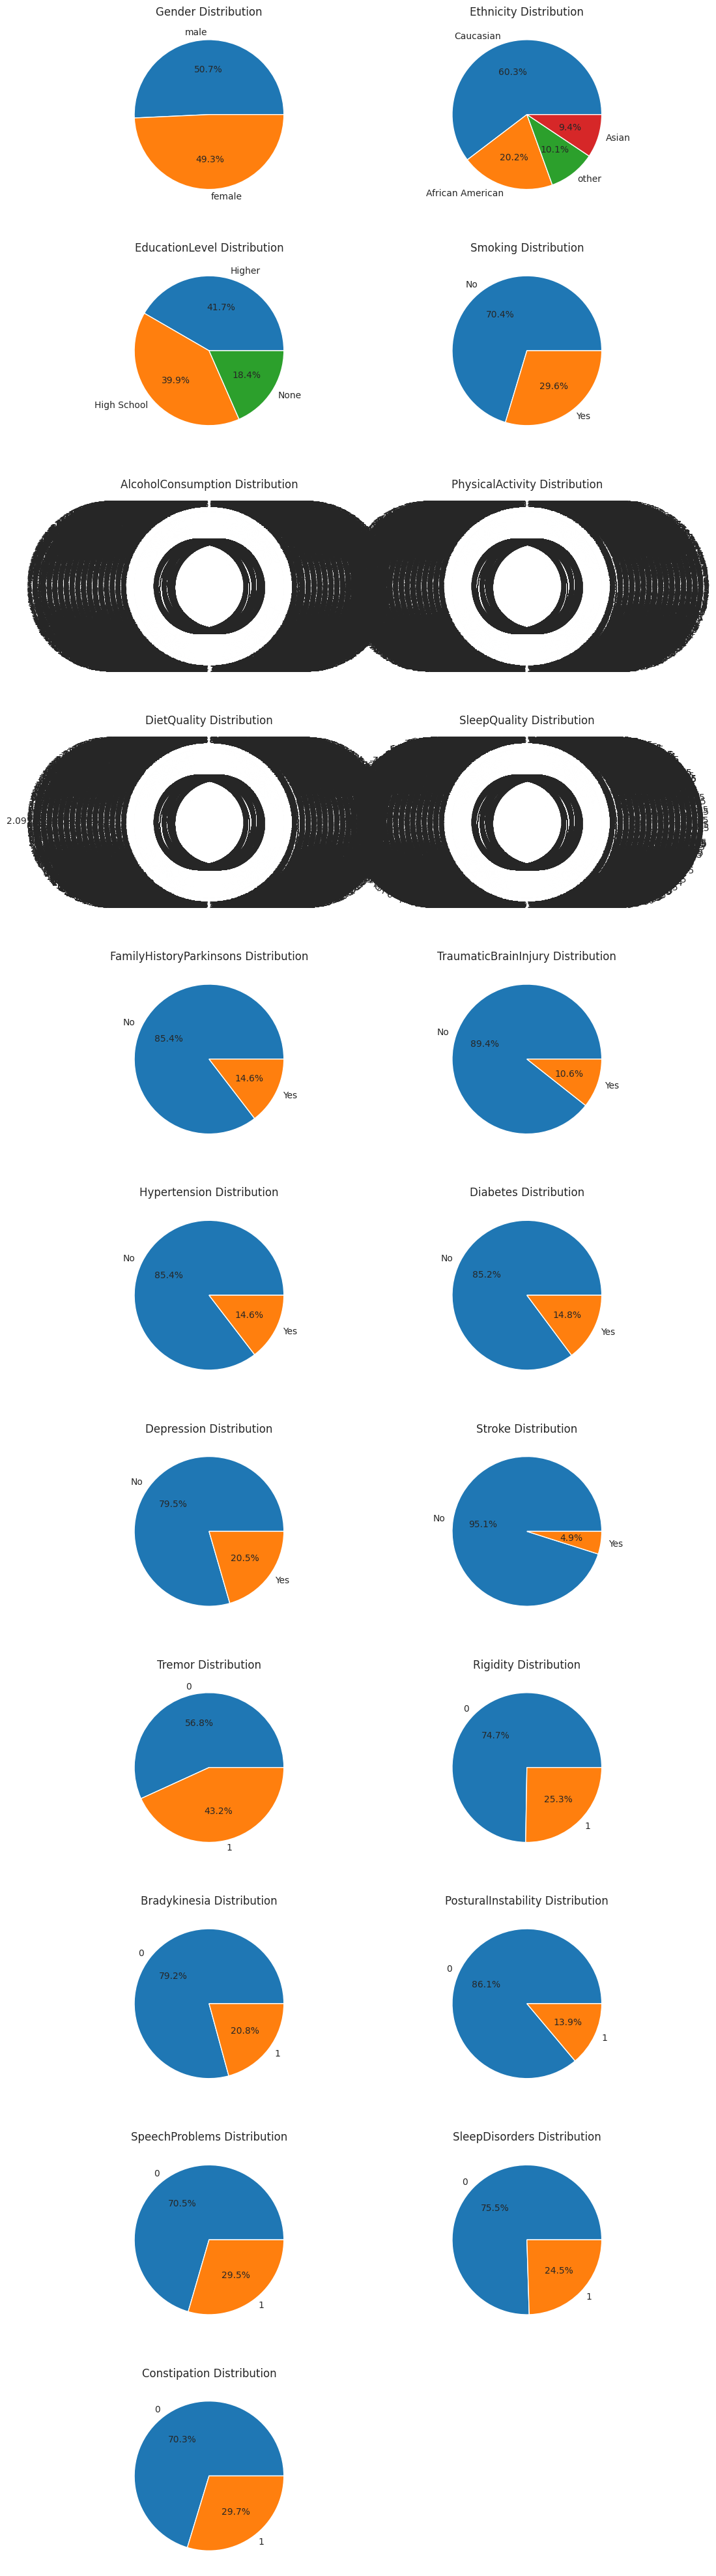

In [78]:
fig, axs = plt.subplots(nrows=len(categorical_columns) // 2 + len(categorical_columns) % 2, ncols=2, figsize=(10, 40))

# Flatten degli assi per facilitarne l'iterazione
axs = axs.flatten()

for i, col in enumerate(categorical_columns):
    counts = data_copy[col].value_counts()
    axs[i].pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%')
    axs[i].set_title(f'{col} Distribution')

# Rimozione degli assi non utilizzati (nel caso di un numero dispari di colonne)
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

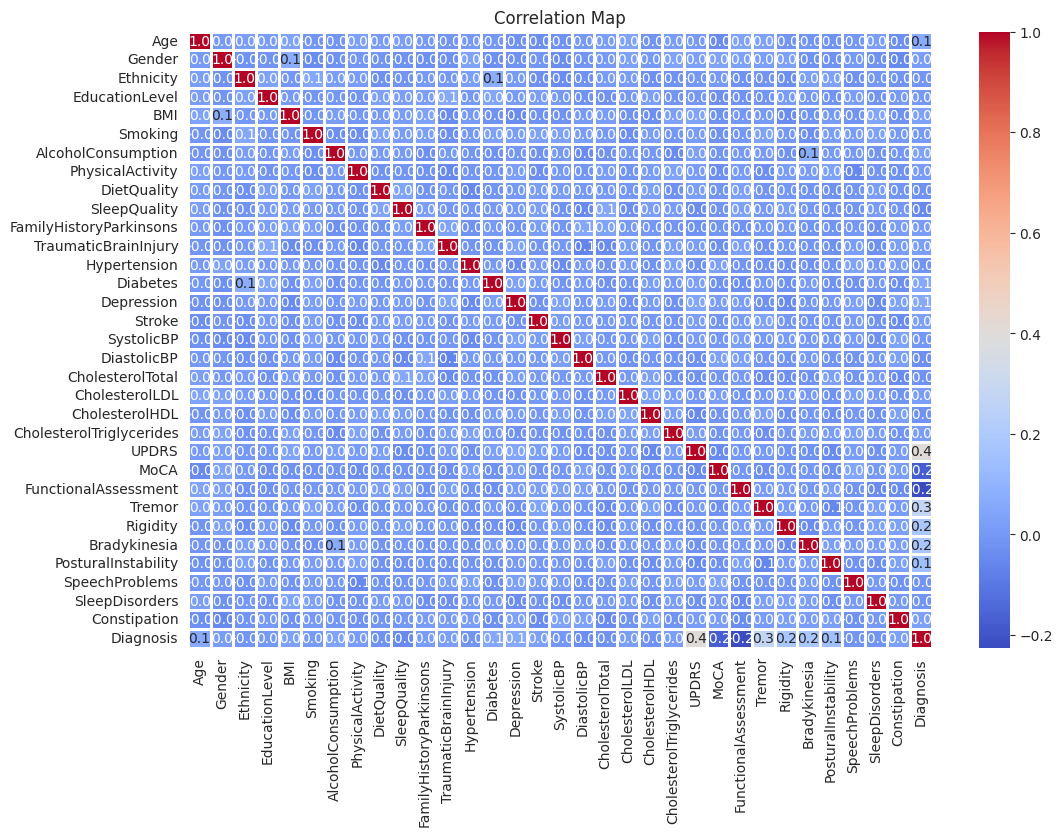

In [79]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.9)
plt.title('Correlation Map')
plt.show()

/tmp/ipython-input-478889029.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


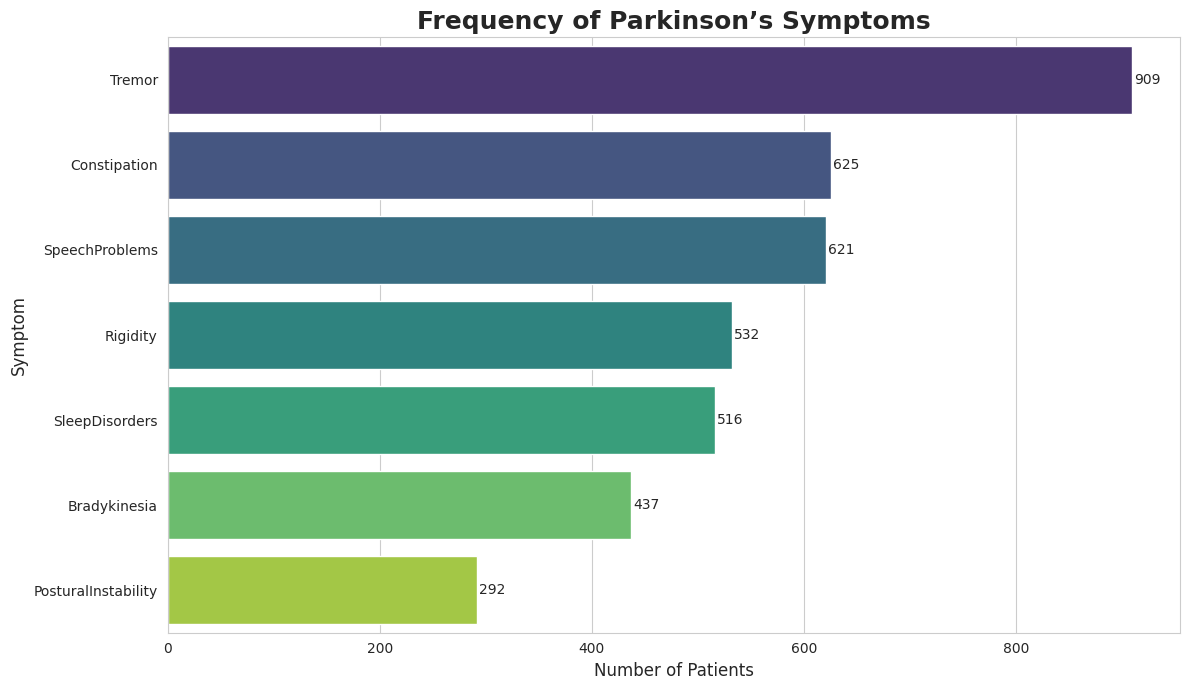

In [80]:
symptom_columns = [
    "Tremor",
    "Constipation",
    "SpeechProblems",
    "Rigidity",
    "SleepDisorders",
    "Bradykinesia",
    "PosturalInstability"
]

# Sum each symptom (counts number of patients showing that symptom)
symptom_counts = dataset[symptom_columns].sum().sort_values(ascending=False)

# Create the horizontal bar chart
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

barplot = sns.barplot(
    x=symptom_counts.values,
    y=symptom_counts.index,
    palette="viridis"
)

# Add count labels to each bar
for i, value in enumerate(symptom_counts.values):
    plt.text(value + 2, i, str(int(value)), va='center', fontsize=10)

plt.title("Frequency of Parkinson’s Symptoms", fontsize=18, fontweight='bold')
plt.xlabel("Number of Patients", fontsize=12)
plt.ylabel("Symptom", fontsize=12)

plt.tight_layout()
plt.show()

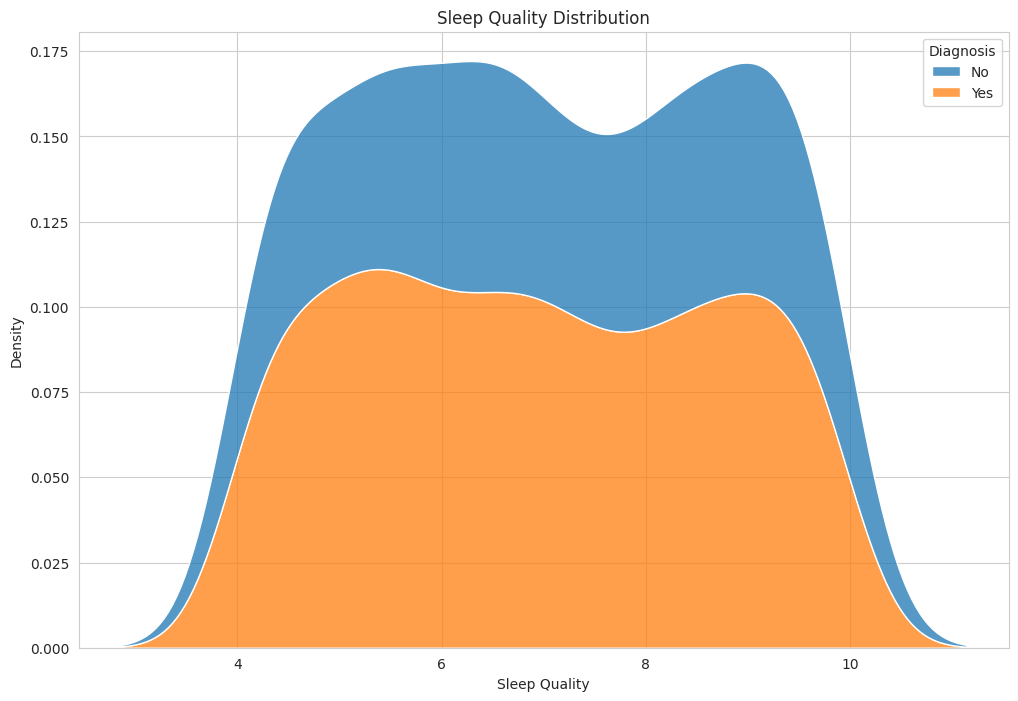

In [81]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data_copy, x="SleepQuality", hue="Diagnosis", multiple="stack")

plt.title('Sleep Quality Distribution')
plt.xlabel('Sleep Quality')
plt.ylabel('Density')
plt.show()

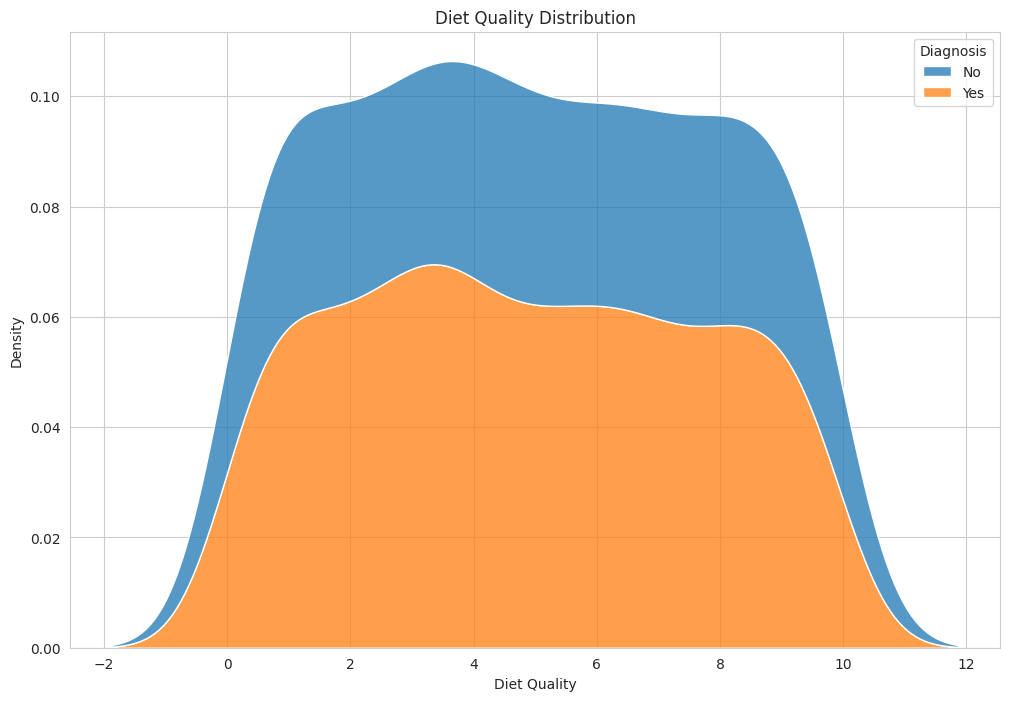

In [82]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data_copy, x="DietQuality", hue="Diagnosis", multiple="stack")

plt.title('Diet Quality Distribution')
plt.xlabel('Diet Quality')
plt.ylabel('Density')
plt.show()

In [83]:
def normalization(dataset, columns):
  pt = PowerTransformer(method='yeo-johnson')

  for col in columns:
    skewness = skew(dataset[col])
    if abs(skewness) > 0.5:
      dataset[col] = pt.fit_transform(dataset[col].values.reshape(-1, 1))
    return dataset

dataset_normalized = normalization(dataset, numerical_columns)

In [84]:
for col in categorical_columns:
  dataset_normalized[col] = dataset[col]

In [85]:
dataset_normalized.head()

Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   85       0          3               1  19.619878        0   
1   75       0          0               2  16.247339        1   
2   70       1          0               0  15.368239        0   
3   52       0          0               0  15.454557        0   
4   87       0          0               1  18.616042        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            5.108241          1.380660     3.893969      9.283194  ...   
1            6.027648          8.409804     8.513428      5.602470  ...   
2            2.242135          0.213275     6.498805      9.929824  ...   
3            5.997788          1.375045     6.715033      4.196189  ...   
4            9.775243          1.188607     4.657572      9.363925  ...   

        MoCA  FunctionalAssessment  Tremor  Rigidity  Bradykinesia  \
0  29.181289              1.572427       1         0             0   
1  12.332639              4.787551       0         1             0   
2  29.927783              2.130686       1         0             0   
3  21.304268              3.391288       1         1             1   
4   8.336364              3.200969       0         0             0   

   PosturalInstability  SpeechProblems  SleepDisorders  Constipation  \
0                    0               0               0             0   
1                    1               0               1             0   
2                    0               1               0             1   
3                    0               0               0             1   
4                    1               0               1             0   

   Diagnosis  
0          0  
1          1  
2          1  
3          1  
4          0  

[5 rows x 33 columns]

In [87]:
dataset.columns

Index(['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryParkinsons', 'TraumaticBrainInjury', 'Hypertension',
       'Diabetes', 'Depression', 'Stroke', 'SystolicBP', 'DiastolicBP',
       'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'UPDRS', 'MoCA', 'FunctionalAssessment',
       'Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability',
       'SpeechProblems', 'SleepDisorders', 'Constipation', 'Diagnosis'],
      dtype='object')

In [88]:
dataset_normalized.columns

Index(['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking',
       'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
       'FamilyHistoryParkinsons', 'TraumaticBrainInjury', 'Hypertension',
       'Diabetes', 'Depression', 'Stroke', 'SystolicBP', 'DiastolicBP',
       'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
       'CholesterolTriglycerides', 'UPDRS', 'MoCA', 'FunctionalAssessment',
       'Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability',
       'SpeechProblems', 'SleepDisorders', 'Constipation', 'Diagnosis'],
      dtype='object')

In [89]:
scaler = StandardScaler()
dataset_normalized[numerical_columns] = scaler.fit_transform(dataset_normalized[numerical_columns])

In [90]:
dataset_normalized.head()

Age  Gender  Ethnicity  EducationLevel       BMI  Smoking  \
0  1.328366       0          3               1 -1.053179        0   
1  0.465684       0          0               2 -1.521172        1   
2  0.034343       1          0               0 -1.643161        0   
3 -1.518484       0          0               0 -1.631183        0   
4  1.500903       0          0               1 -1.192477        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            5.108241          1.380660     3.893969      9.283194  ...   
1            6.027648          8.409804     8.513428      5.602470  ...   
2            2.242135          0.213275     6.498805      9.929824  ...   
3            5.997788          1.375045     6.715033      4.196189  ...   
4            9.775243          1.188607     4.657572      9.363925  ...   

       MoCA  FunctionalAssessment  Tremor  Rigidity  Bradykinesia  \
0  1.630256             -1.165038       1         0             0   
1 -0.319603             -0.068916       0         1             0   
2  1.716646             -0.974713       1         0             0   
3  0.718665             -0.544940       1         1             1   
4 -0.782083             -0.609825       0         0             0   

   PosturalInstability  SpeechProblems  SleepDisorders  Constipation  \
0                    0               0               0             0   
1                    1               0               1             0   
2                    0               1               0             1   
3                    0               0               0             1   
4                    1               0               1             0   

   Diagnosis  
0          0  
1          1  
2          1  
3          1  
4          0  

[5 rows x 33 columns]

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Models with 70-30

Training Logistic Regression...
✓ Logistic Regression completed successfully


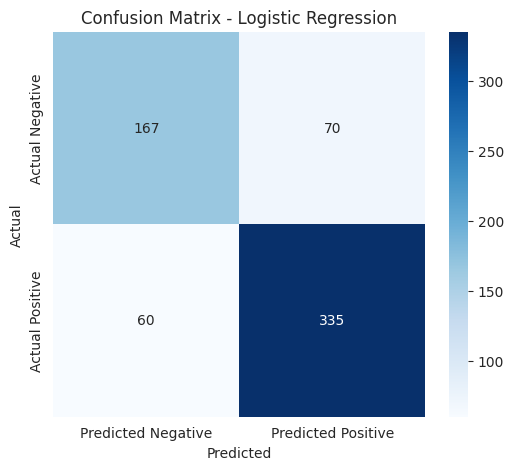

Training Random Forest...
✓ Random Forest completed successfully


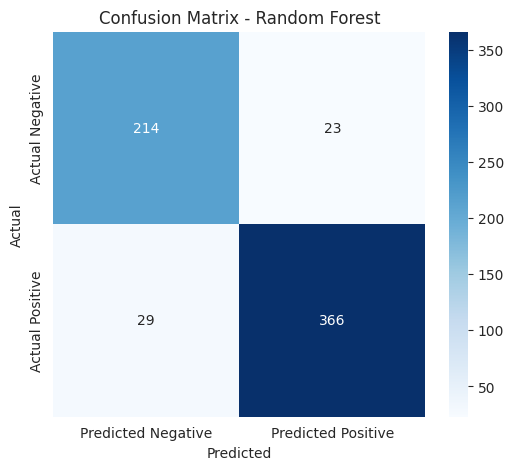

Training SVM...
✓ SVM completed successfully


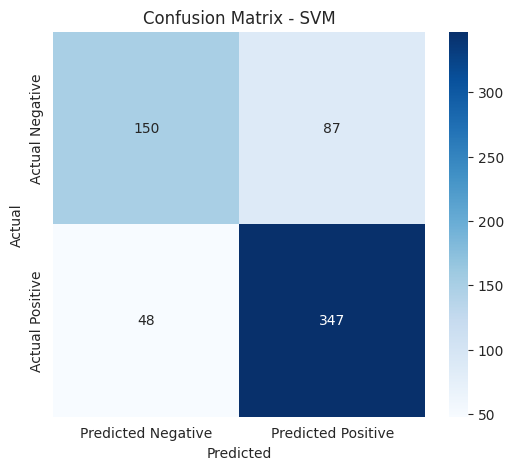

Training KNN...
✓ KNN completed successfully


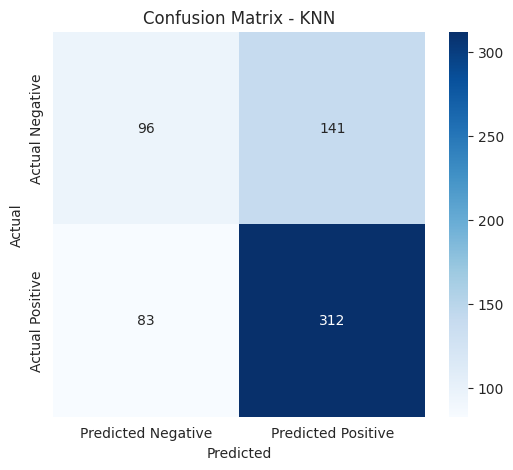

Training Decision Tree...
✓ Decision Tree completed successfully


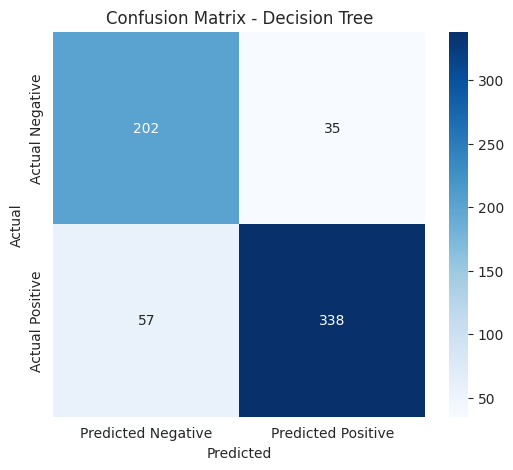

Training CatBoost...
✓ CatBoost completed successfully


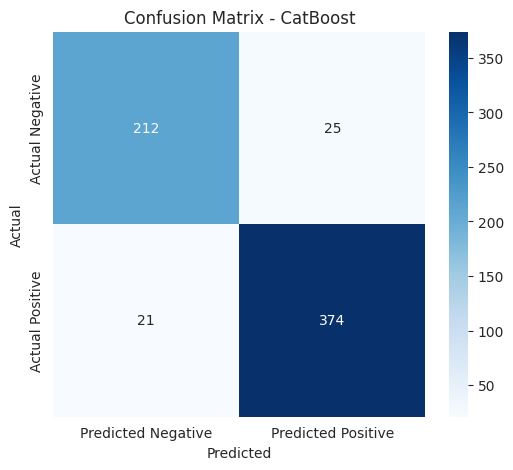

Training Linear Discriminant Analysis...
✓ Linear Discriminant Analysis completed successfully


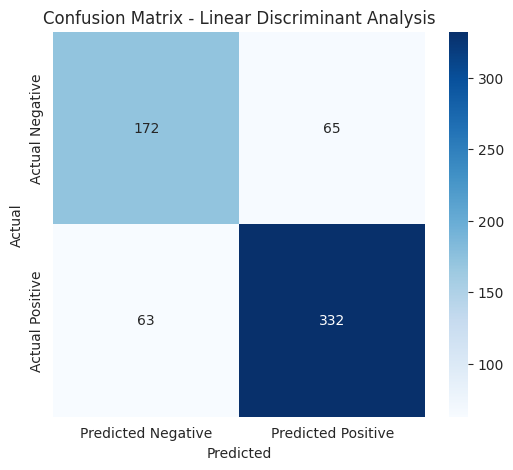

Training Naive Bayes...
✓ Naive Bayes completed successfully


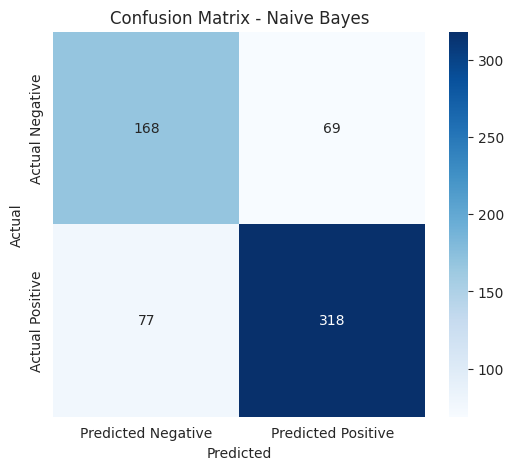

Training XGBoost...
✓ XGBoost completed successfully


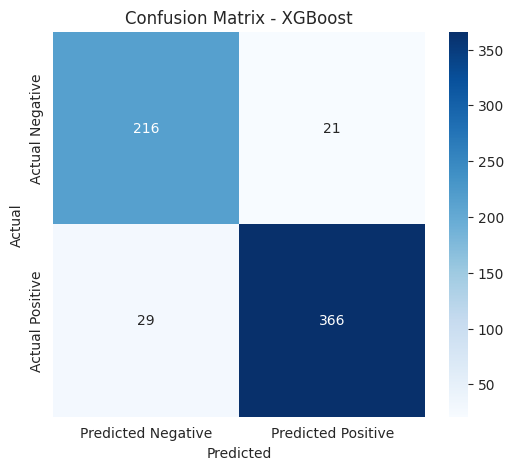

Training Gradient Boosting...
✓ Gradient Boosting completed successfully


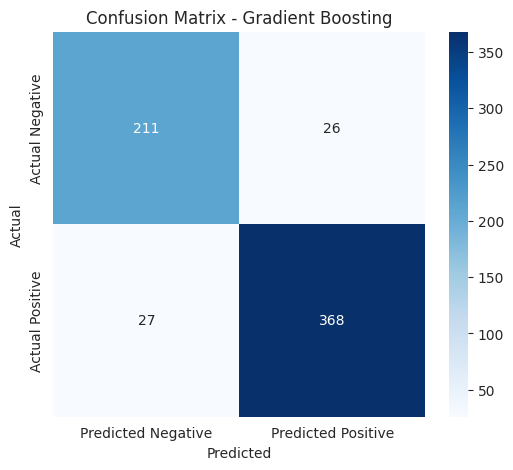

Training AdaBoost...
✓ AdaBoost completed successfully


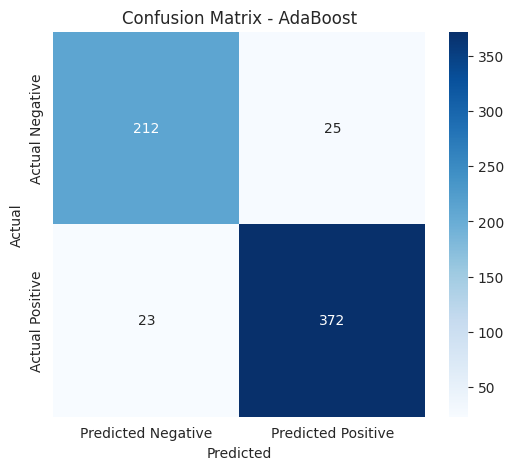


Model Performance Summary:
                              Accuracy  Precision  Recall  Specificity  \
Model                                                                    
Logistic Regression             0.7943     0.8272  0.8481       0.7046   
Random Forest                   0.9177     0.9409  0.9266       0.9030   
SVM                             0.7864     0.7995  0.8785       0.6329   
KNN                             0.6456     0.6887  0.7899       0.4051   
Decision Tree                   0.8544     0.9062  0.8557       0.8523   
CatBoost                        0.9272     0.9373  0.9468       0.8945   
Linear Discriminant Analysis    0.7975     0.8363  0.8405       0.7257   
Naive Bayes                     0.7690     0.8217  0.8051       0.7089   
XGBoost                         0.9209     0.9457  0.9266       0.9114   
Gradient Boosting               0.9161     0.9340  0.9316       0.8903   
AdaBoost                        0.9241     0.9370  0.9418       0.8945   

         

In [127]:
X = dataset_normalized.drop(columns=['Diagnosis'])
y = dataset_normalized['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

metrics = []
# Dictionary to store y_proba for each model
y_proba_dict = {}

for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Store y_proba in dictionary for later use
        y_proba_dict[name] = y_proba

        # Confusion matrix for specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        # Scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        metrics.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1": f1,
            "AUC": auc_score,
            "PR AUC": pr_auc
        })

        print(f"✓ {name} completed successfully")

        # Confusion Matrix Visualization
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                   xticklabels=['Predicted Negative', 'Predicted Positive'],
                   yticklabels=['Actual Negative', 'Actual Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")
        # Add failed model with NaN values
        metrics.append({
            "Model": name,
            "Accuracy": np.nan,
            "Precision": np.nan,
            "Recall": np.nan,
            "Specificity": np.nan,
            "F1": np.nan,
            "AUC": np.nan,
            "PR AUC": np.nan
        })
        # Add None to y_proba_dict for failed models
        y_proba_dict[name] = None

metrics_df = pd.DataFrame(metrics).set_index("Model")

# Display the results
print("\nModel Performance Summary:")
print(metrics_df.round(4))

In [128]:
metrics_df.head(11)

Accuracy  Precision    Recall  Specificity  \
Model                                                                      
Logistic Regression           0.794304   0.827160  0.848101     0.704641   
Random Forest                 0.917722   0.940874  0.926582     0.902954   
SVM                           0.786392   0.799539  0.878481     0.632911   
KNN                           0.645570   0.688742  0.789873     0.405063   
Decision Tree                 0.854430   0.906166  0.855696     0.852321   
CatBoost                      0.927215   0.937343  0.946835     0.894515   
Linear Discriminant Analysis  0.797468   0.836272  0.840506     0.725738   
Naive Bayes                   0.768987   0.821705  0.805063     0.708861   
XGBoost                       0.920886   0.945736  0.926582     0.911392   
Gradient Boosting             0.916139   0.934010  0.931646     0.890295   
AdaBoost                      0.924051   0.937028  0.941772     0.894515   

                                    F1       AUC    PR AUC  
Model                                                       
Logistic Regression           0.837500  0.891129  0.932397  
Random Forest                 0.933673  0.950093  0.955366  
SVM                           0.837153  0.867201  0.915120  
KNN                           0.735849  0.631966  0.704350  
Decision Tree                 0.880208  0.854008  0.865593  
CatBoost                      0.942065  0.966715  0.972447  
Linear Discriminant Analysis  0.838384  0.889857  0.932389  
Naive Bayes                   0.813299  0.850868  0.896635  
XGBoost                       0.936061  0.962356  0.970645  
Gradient Boosting             0.932826  0.958538  0.969464  
AdaBoost                      0.939394  0.957256  0.968466

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


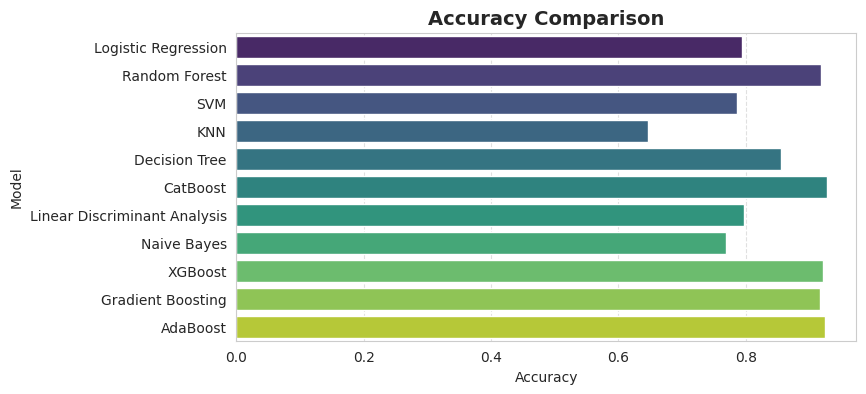

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


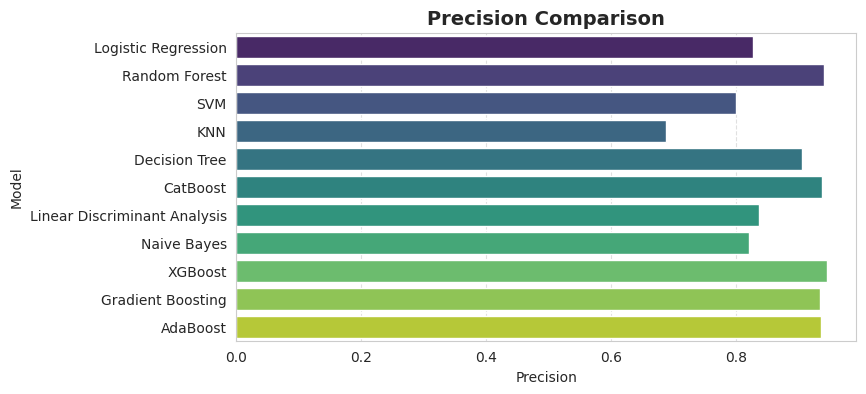

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


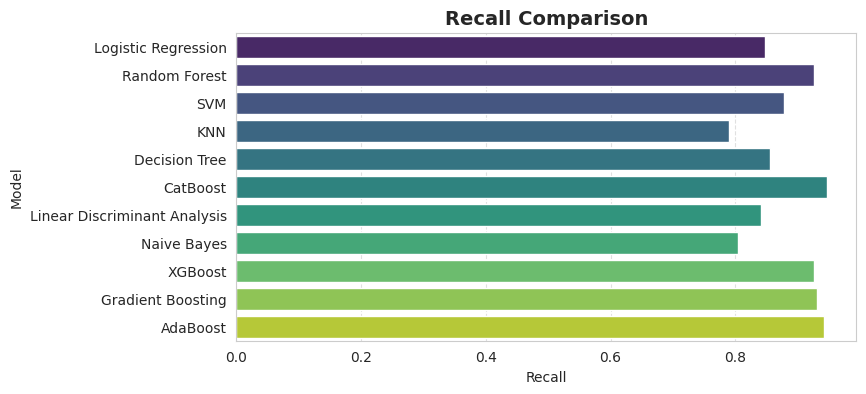

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


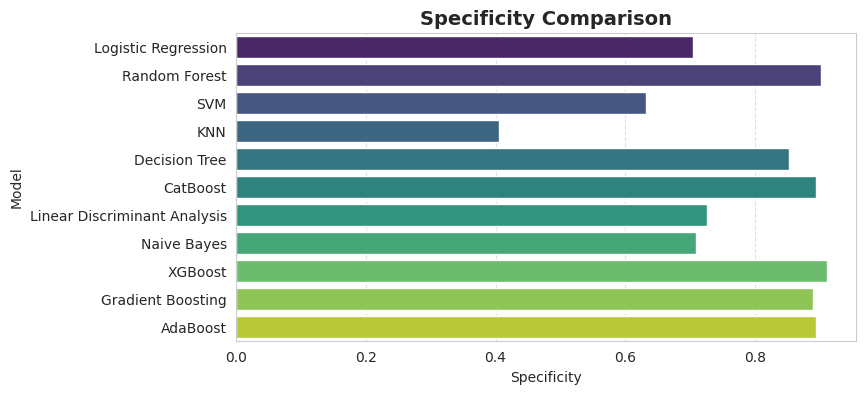

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


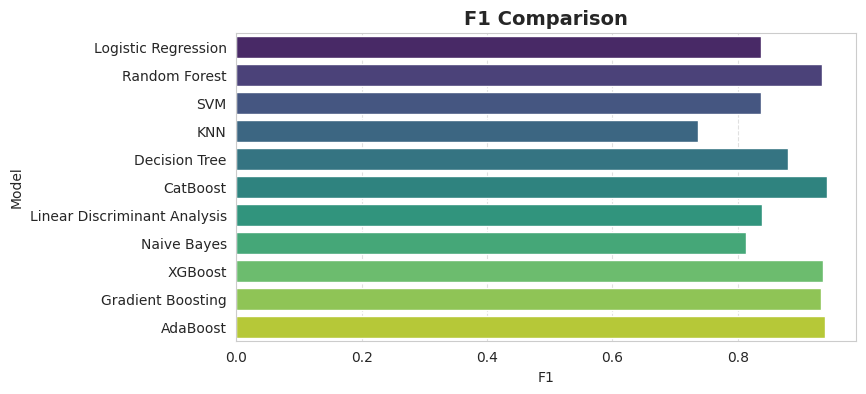

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


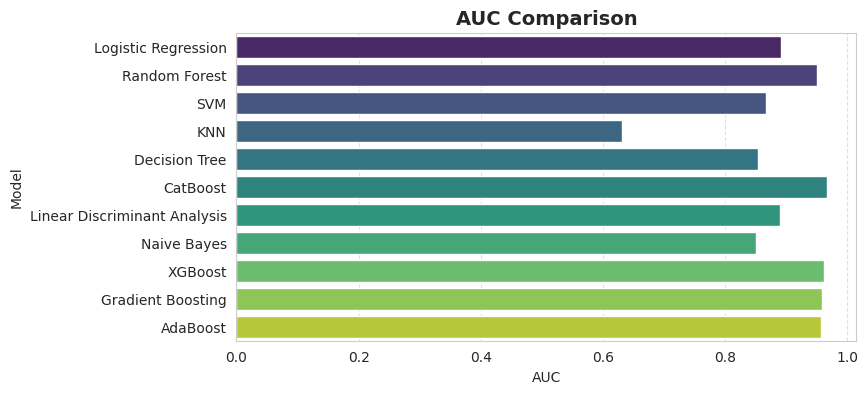

/tmp/ipython-input-2302290786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)


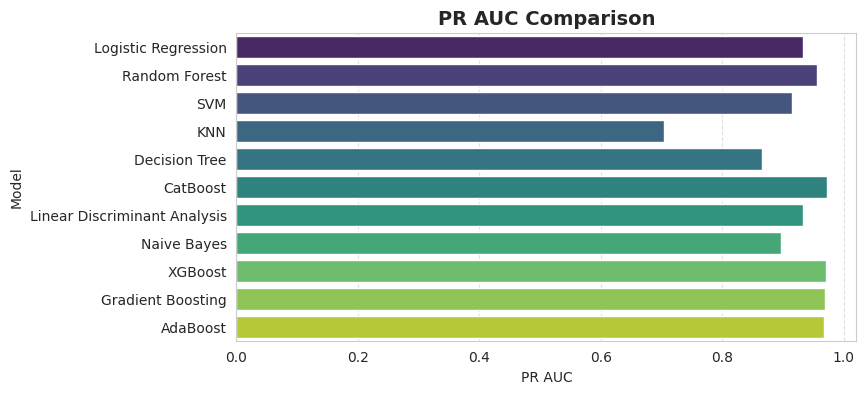

In [129]:
def plot_bar(metric_name, color='viridis'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=metrics_df[metric_name], y=metrics_df.index, palette=color)
    plt.title(f"{metric_name} Comparison", fontsize=14, fontweight='bold')
    plt.xlabel(metric_name)
    plt.ylabel("Model")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

for metric in ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC", "PR AUC"]:
    plot_bar(metric)

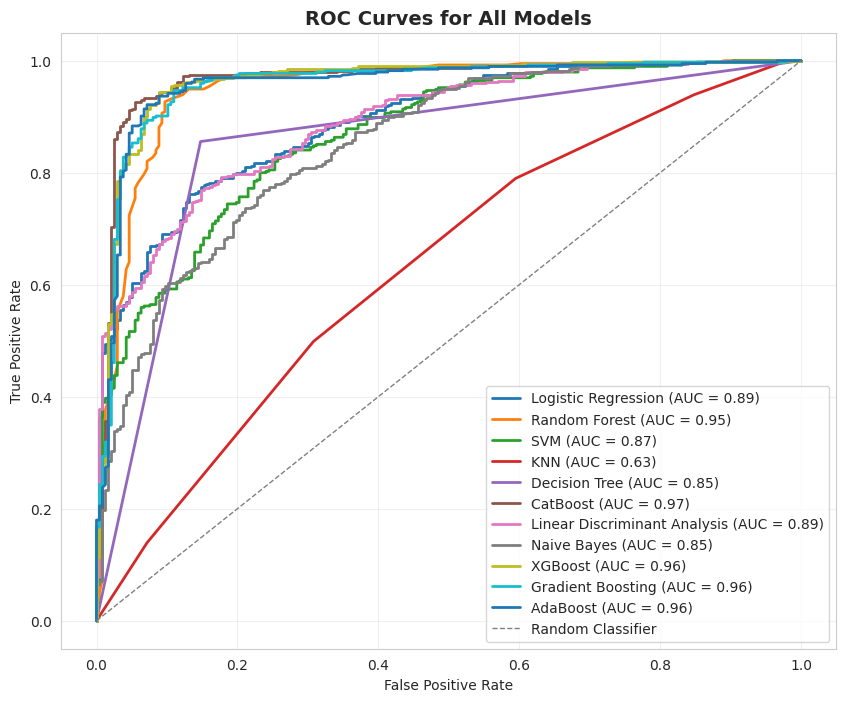

In [130]:
plt.figure(figsize=(10, 8))
for name, y_proba in y_proba_dict.items():
    if y_proba is not None:  # Only plot for successful models
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.title('ROC Curves for All Models', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

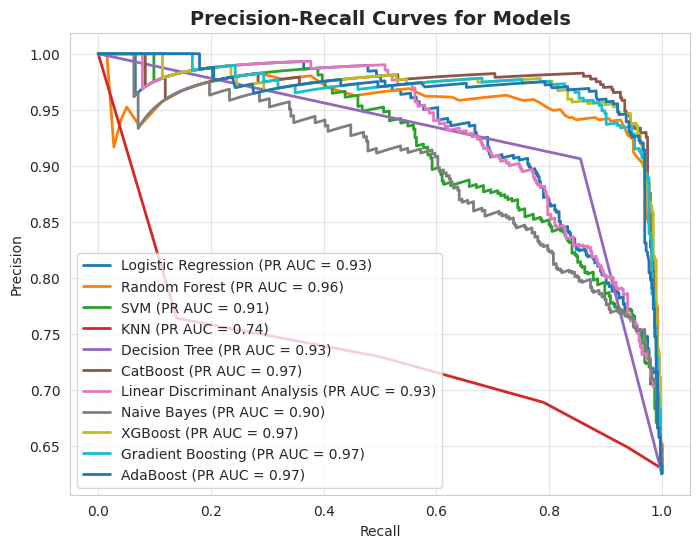

In [132]:
plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (PR AUC = {pr_auc:.2f})')

plt.title('Precision-Recall Curves for Models', fontsize=14, fontweight='bold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.show()

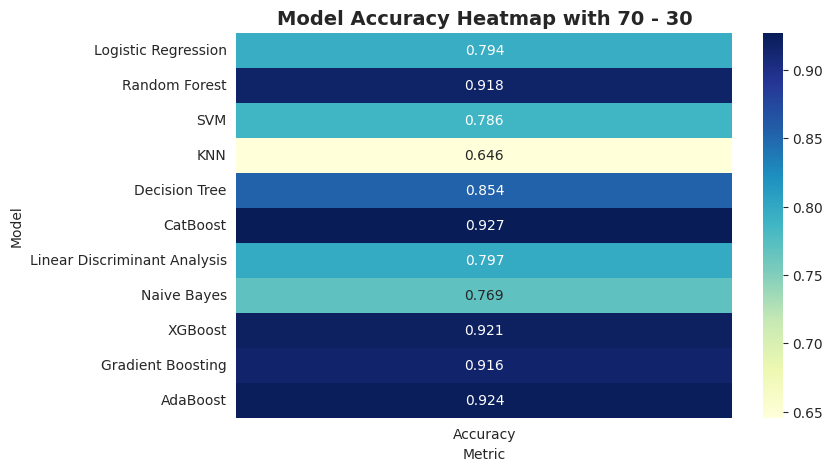

In [141]:
plt.figure(figsize=(8, 5))
sns.heatmap(metrics_df[["Accuracy"]], annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Model Accuracy Heatmap with 70 - 30", fontsize=14, fontweight="bold")
plt.xlabel("Metric")
plt.ylabel("Model")
plt.show()

# Model training with 60-40

Training Logistic Regression...
✓ Logistic Regression completed successfully


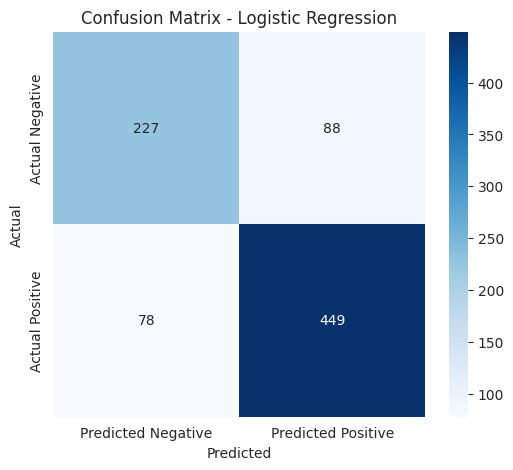

Training Random Forest...
✓ Random Forest completed successfully


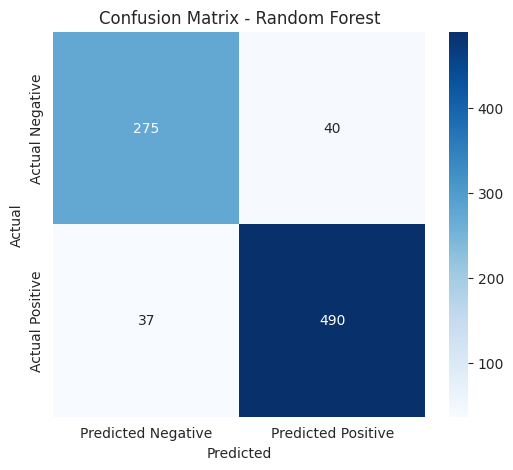

Training SVM...
✓ SVM completed successfully


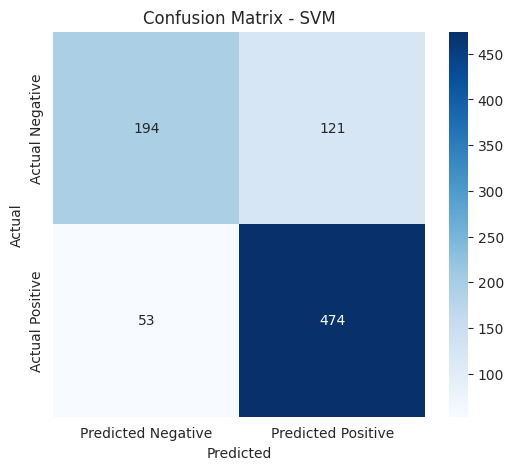

Training KNN...
✓ KNN completed successfully


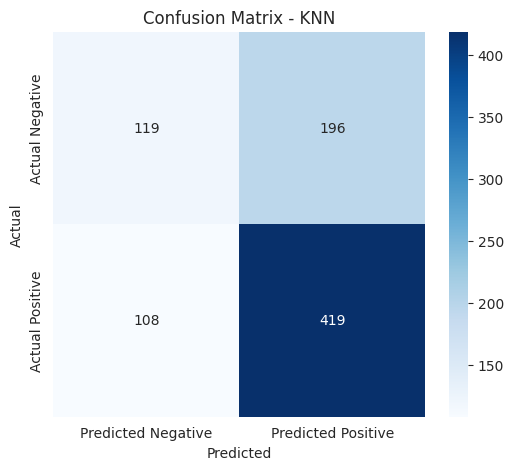

Training Decision Tree...
✓ Decision Tree completed successfully


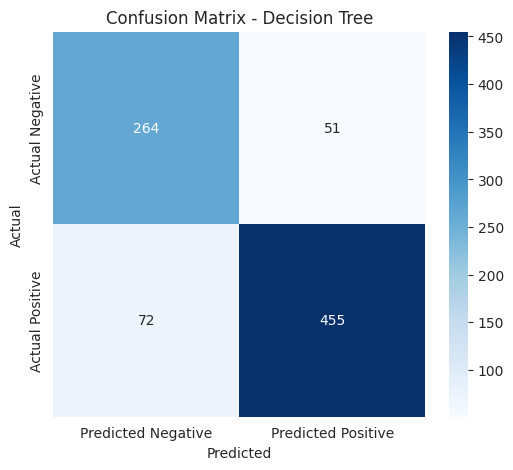

Training CatBoost...
✓ CatBoost completed successfully


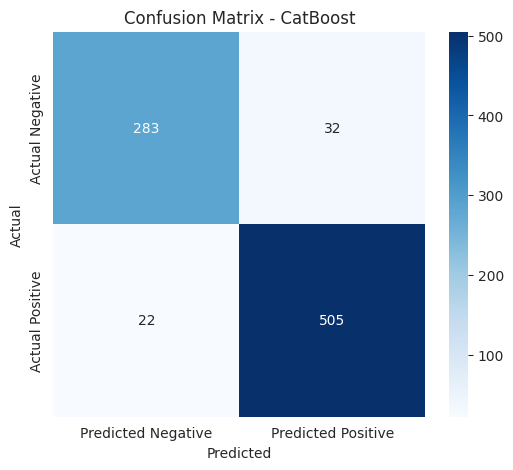

Training Linear Discriminant Analysis...
✓ Linear Discriminant Analysis completed successfully


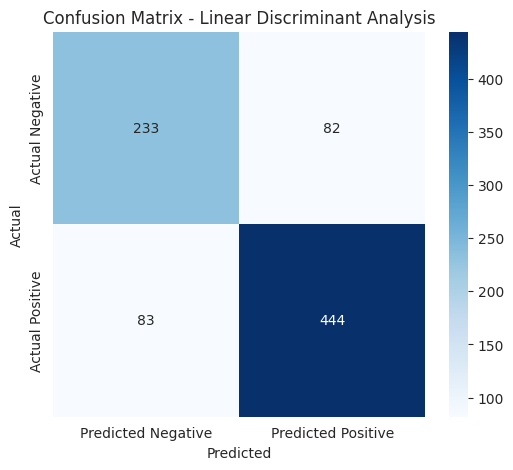

Training Naive Bayes...
✓ Naive Bayes completed successfully


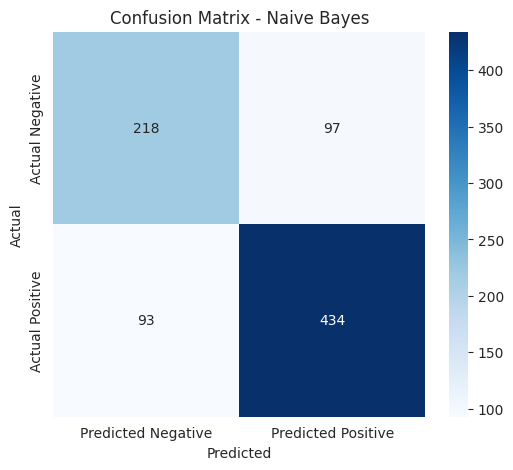

Training XGBoost...
✓ XGBoost completed successfully


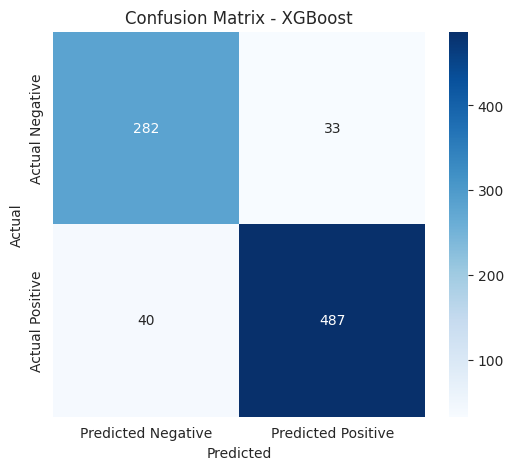

Training Gradient Boosting...
✓ Gradient Boosting completed successfully


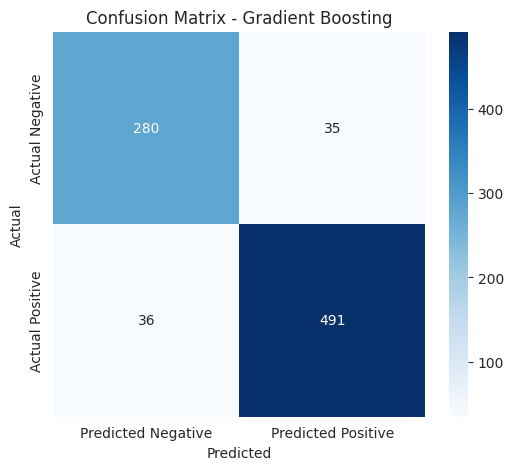

Training AdaBoost...
✓ AdaBoost completed successfully


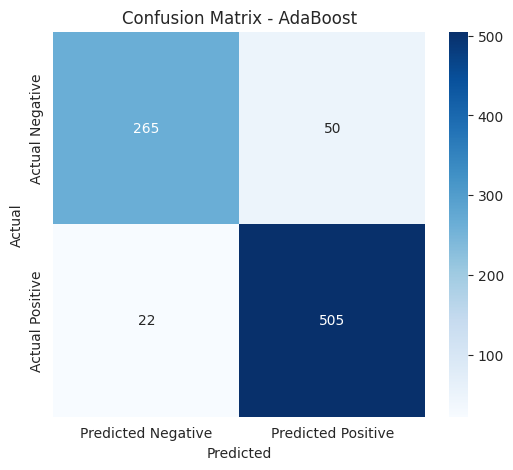


Model Performance Summary:
                              Accuracy  Precision  Recall  Specificity  \
Model                                                                    
Logistic Regression             0.7943     0.8272  0.8481       0.7046   
Random Forest                   0.9177     0.9409  0.9266       0.9030   
SVM                             0.7864     0.7995  0.8785       0.6329   
KNN                             0.6456     0.6887  0.7899       0.4051   
Decision Tree                   0.8544     0.9062  0.8557       0.8523   
CatBoost                        0.9272     0.9373  0.9468       0.8945   
Linear Discriminant Analysis    0.7975     0.8363  0.8405       0.7257   
Naive Bayes                     0.7690     0.8217  0.8051       0.7089   
XGBoost                         0.9209     0.9457  0.9266       0.9114   
Gradient Boosting               0.9161     0.9340  0.9316       0.8903   
AdaBoost                        0.9241     0.9370  0.9418       0.8945   

         

In [134]:
X = dataset_normalized.drop(columns=['Diagnosis'])
y = dataset_normalized['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

metrics = []
# Dictionary to store y_proba for each model
y_proba_dict_1 = {}

for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Store y_proba in dictionary for later use
        y_proba_dict_1[name] = y_proba

        # Confusion matrix for specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        # Scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        metrics.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1": f1,
            "AUC": auc_score,
            "PR AUC": pr_auc
        })

        print(f"✓ {name} completed successfully")

        # Confusion Matrix Visualization
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                   xticklabels=['Predicted Negative', 'Predicted Positive'],
                   yticklabels=['Actual Negative', 'Actual Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")
        # Add failed model with NaN values
        metrics.append({
            "Model": name,
            "Accuracy": np.nan,
            "Precision": np.nan,
            "Recall": np.nan,
            "Specificity": np.nan,
            "F1": np.nan,
            "AUC": np.nan,
            "PR AUC": np.nan
        })
        # Add None to y_proba_dict for failed models
        y_proba_dict_1[name] = None

metrics_df_1 = pd.DataFrame(metrics).set_index("Model")

# Display the results
print("\nModel Performance Summary:")
print(metrics_df_1.round(4))

In [135]:
metrics_df_1.head(11)

Accuracy  Precision    Recall  Specificity  \
Model                                                                      
Logistic Regression           0.802850   0.836127  0.851992     0.720635   
Random Forest                 0.908551   0.924528  0.929791     0.873016   
SVM                           0.793349   0.796639  0.899431     0.615873   
KNN                           0.638955   0.681301  0.795066     0.377778   
Decision Tree                 0.853919   0.899209  0.863378     0.838095   
CatBoost                      0.935867   0.940410  0.958254     0.898413   
Linear Discriminant Analysis  0.804038   0.844106  0.842505     0.739683   
Naive Bayes                   0.774347   0.817326  0.823529     0.692063   
XGBoost                       0.913302   0.936538  0.924099     0.895238   
Gradient Boosting             0.915677   0.933460  0.931689     0.888889   
AdaBoost                      0.914489   0.909910  0.958254     0.841270   

                                    F1       AUC    PR AUC  
Model                                                       
Logistic Regression           0.843985  0.898726  0.938526  
Random Forest                 0.927152  0.950218  0.963109  
SVM                           0.844920  0.868721  0.916535  
KNN                           0.733800  0.610578  0.688043  
Decision Tree                 0.880929  0.850736  0.861868  
CatBoost                      0.949248  0.970013  0.976728  
Linear Discriminant Analysis  0.843305  0.896798  0.937985  
Naive Bayes                   0.820416  0.858974  0.907314  
XGBoost                       0.930277  0.962447  0.973193  
Gradient Boosting             0.932574  0.959787  0.967337  
AdaBoost                      0.933457  0.957815  0.972515

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


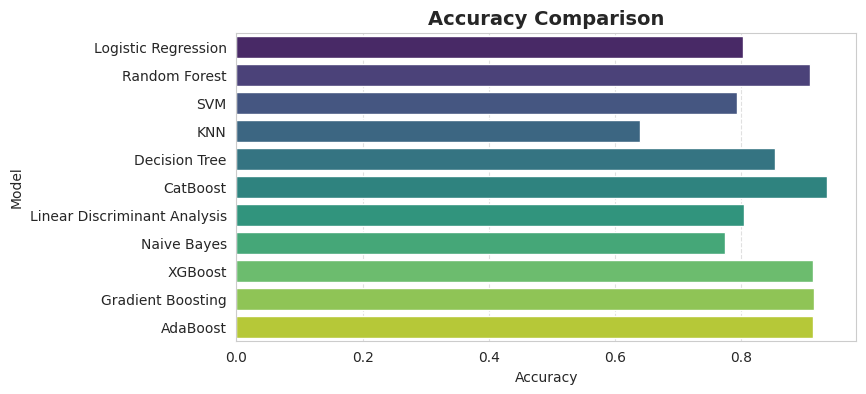

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


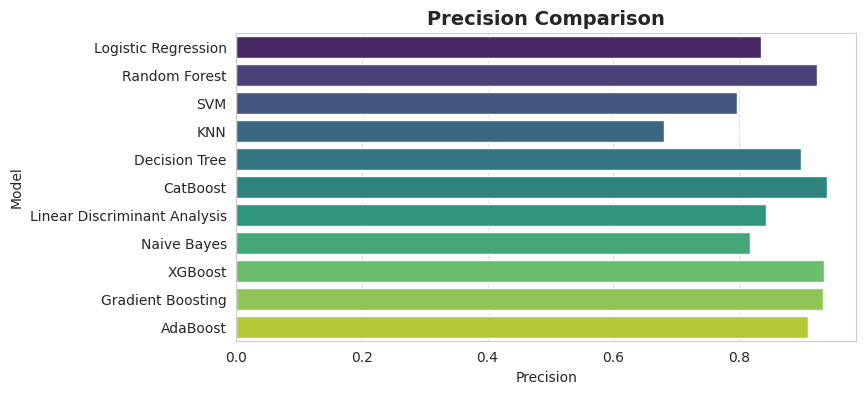

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


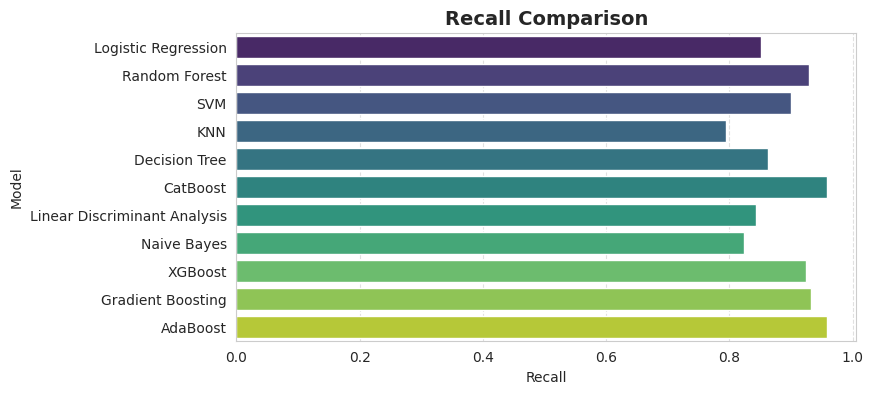

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


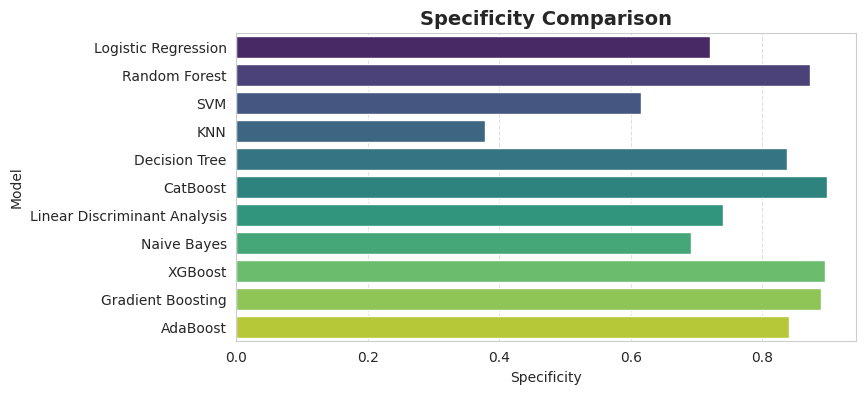

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


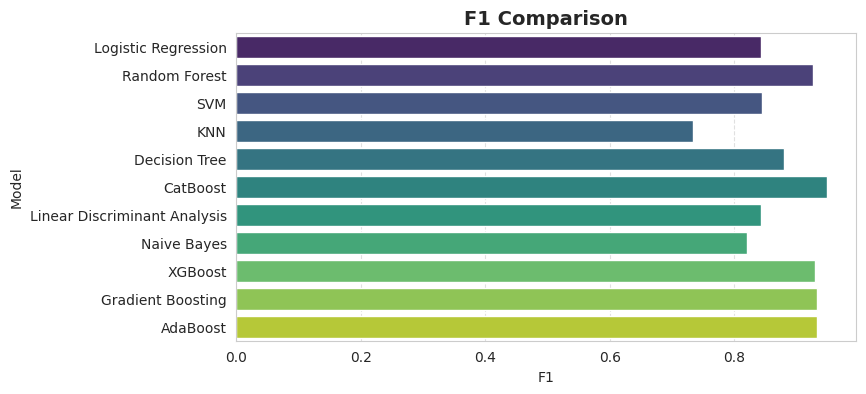

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


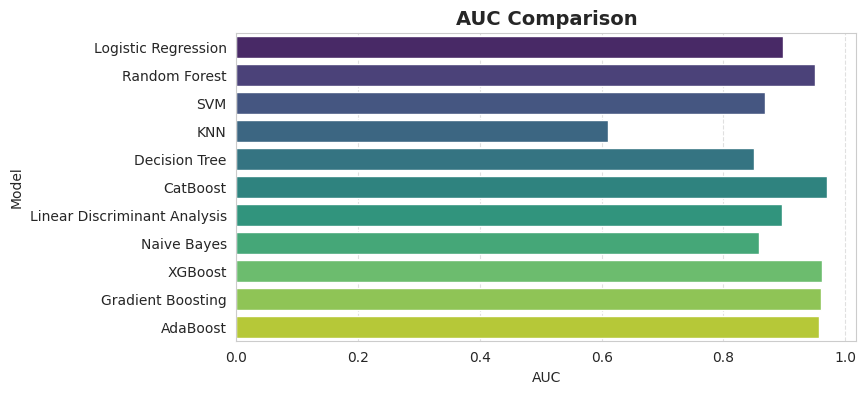

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


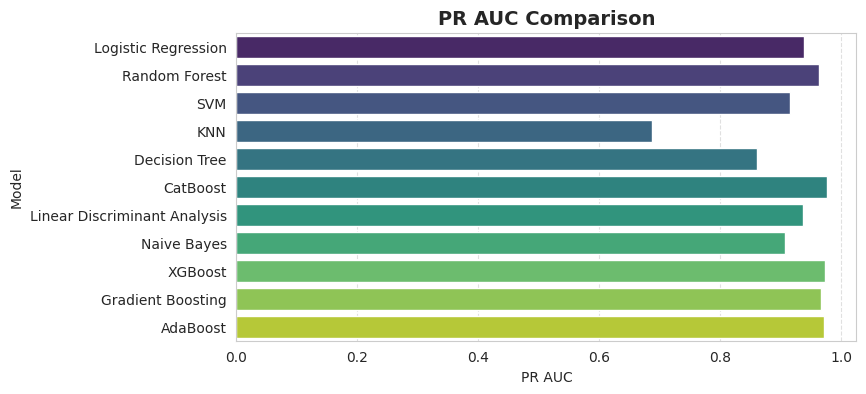

In [136]:
def plot_bar(metric_name, color='viridis'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)
    plt.title(f"{metric_name} Comparison", fontsize=14, fontweight='bold')
    plt.xlabel(metric_name)
    plt.ylabel("Model")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

for metric in ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC", "PR AUC"]:
    plot_bar(metric)

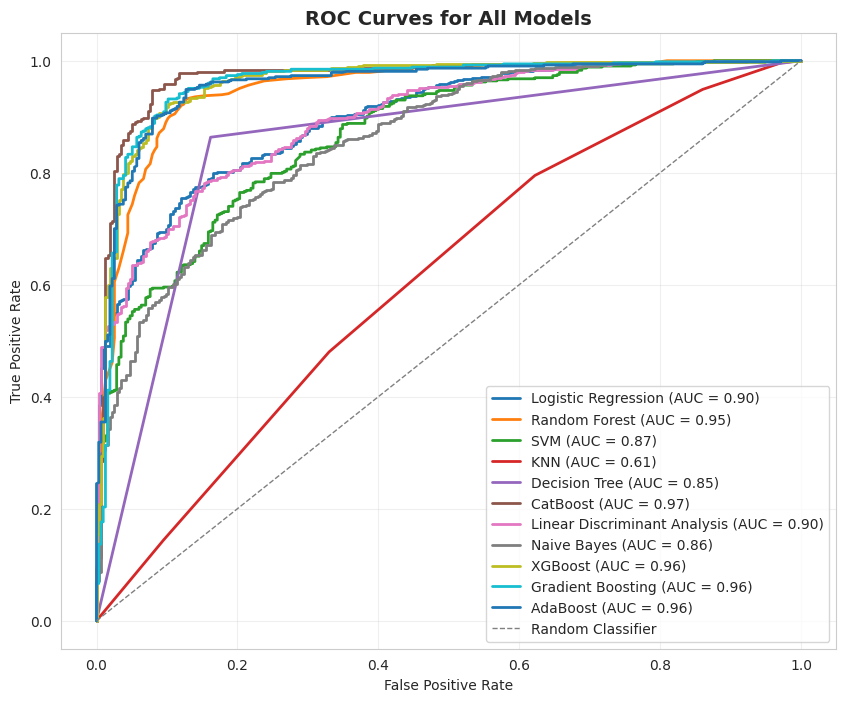

In [138]:
plt.figure(figsize=(10, 8))
for name, y_proba in y_proba_dict_1.items():
    if y_proba is not None:  # Only plot for successful models
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.title('ROC Curves for All Models', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

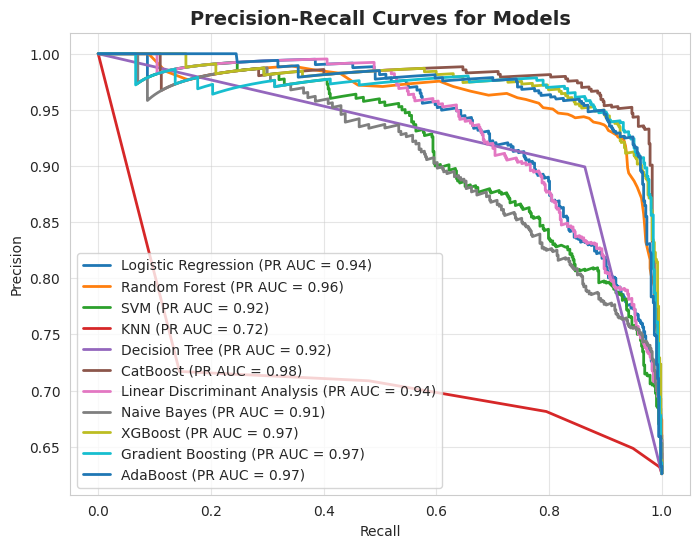

In [139]:
plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict_1.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (PR AUC = {pr_auc:.2f})')

plt.title('Precision-Recall Curves for Models', fontsize=14, fontweight='bold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.show()

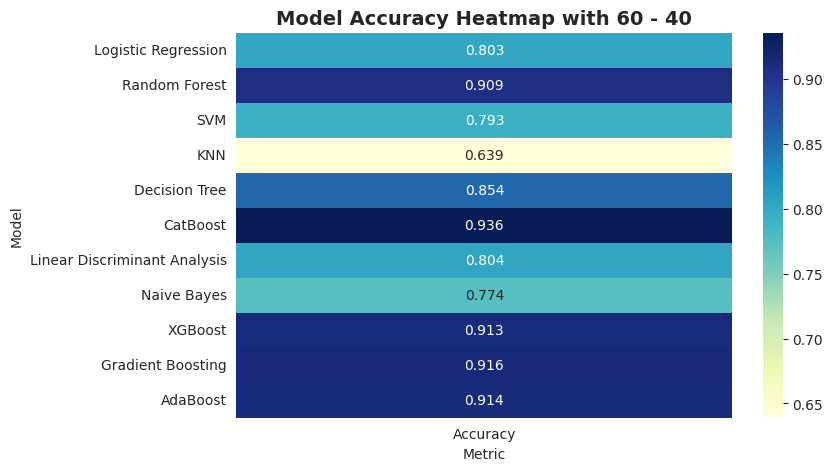

In [142]:
plt.figure(figsize=(8, 5))
sns.heatmap(metrics_df_1[["Accuracy"]], annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Model Accuracy Heatmap with 60 - 40", fontsize=14, fontweight="bold")
plt.xlabel("Metric")
plt.ylabel("Model")
plt.show()

# model with 50 - 50

Training Logistic Regression...
✓ Logistic Regression completed successfully


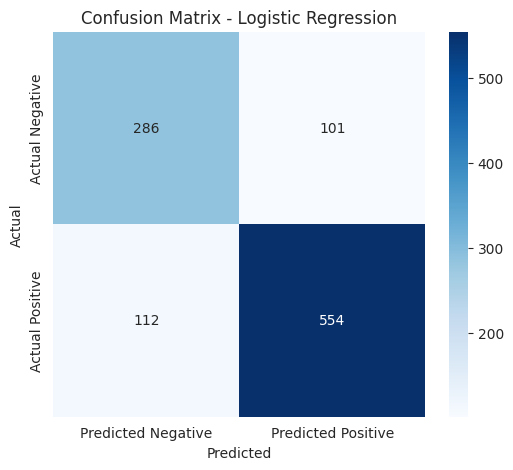

Training Random Forest...
✓ Random Forest completed successfully


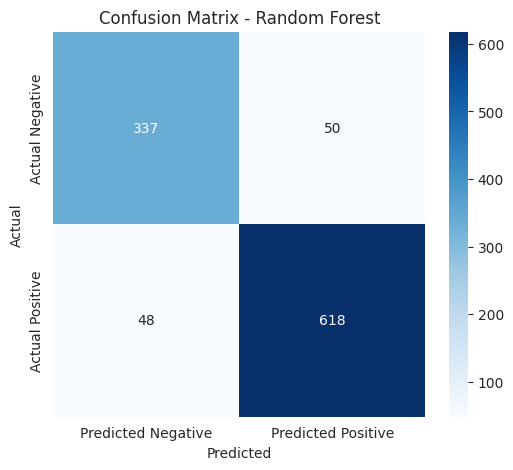

Training SVM...
✓ SVM completed successfully


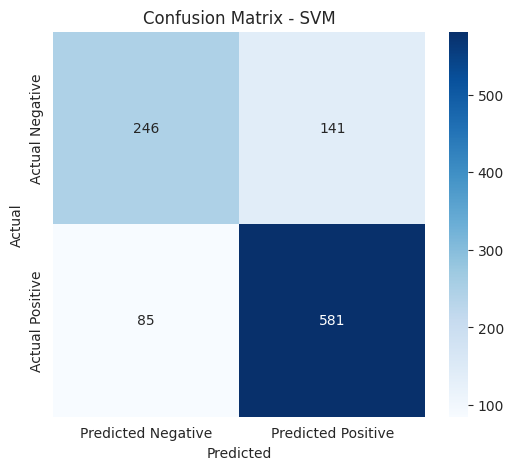

Training KNN...
✓ KNN completed successfully


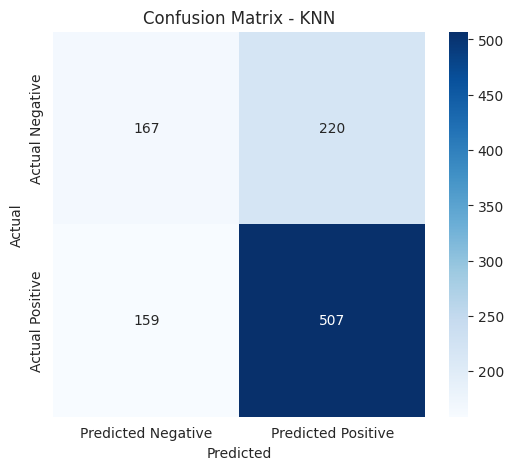

Training Decision Tree...
✓ Decision Tree completed successfully


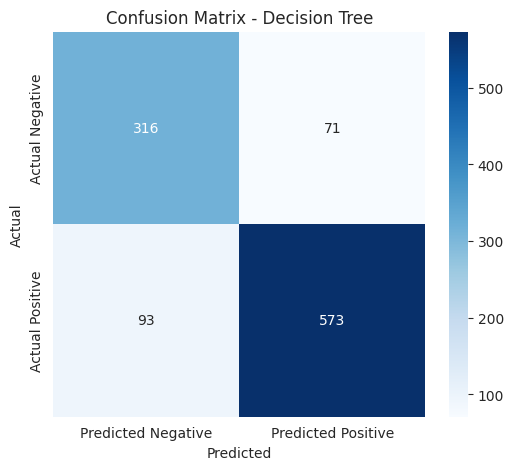

Training CatBoost...
✓ CatBoost completed successfully


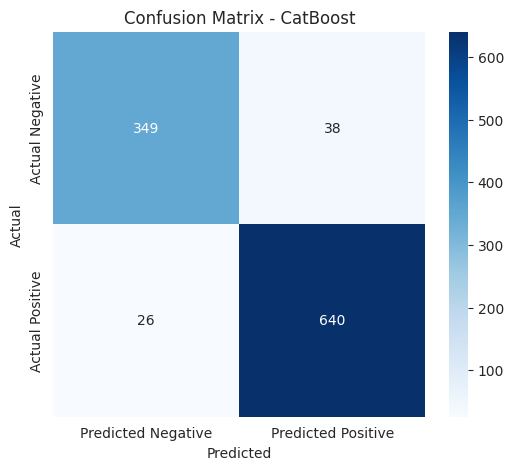

Training Linear Discriminant Analysis...
✓ Linear Discriminant Analysis completed successfully


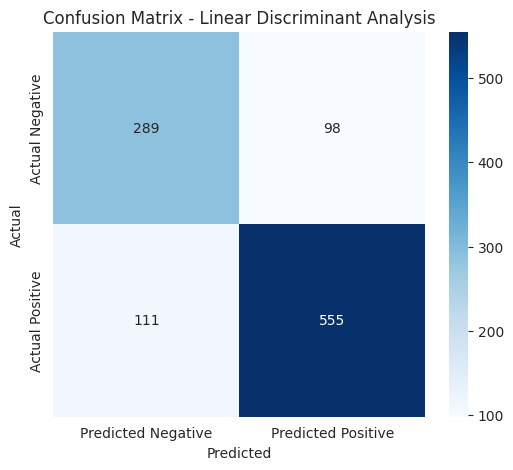

Training Naive Bayes...
✓ Naive Bayes completed successfully


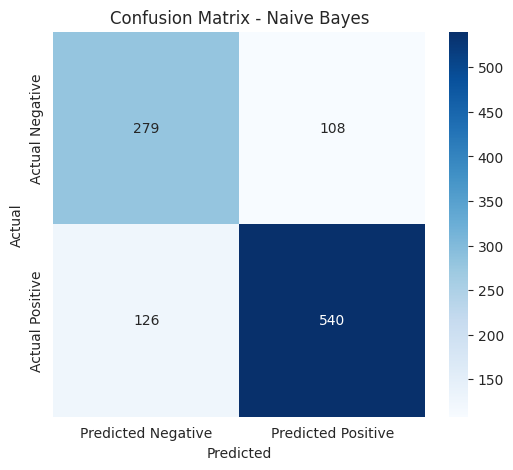

Training XGBoost...
✓ XGBoost completed successfully


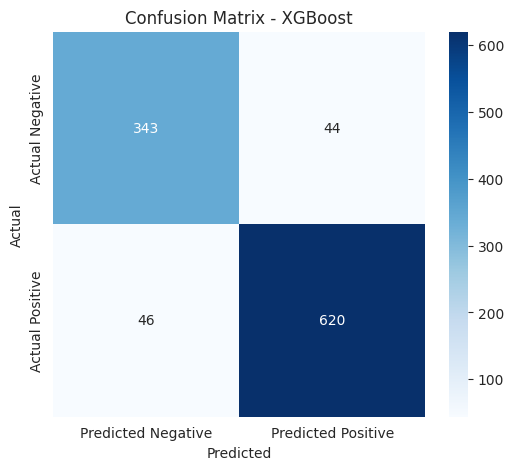

Training Gradient Boosting...
✓ Gradient Boosting completed successfully


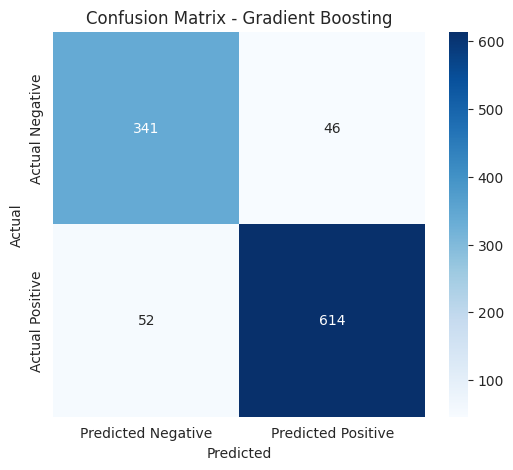

Training AdaBoost...
✓ AdaBoost completed successfully


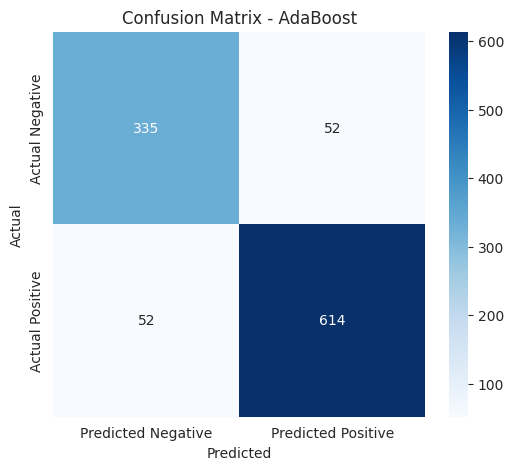


Model Performance Summary:
                              Accuracy  Precision  Recall  Specificity  \
Model                                                                    
Logistic Regression             0.7977     0.8458  0.8318       0.7390   
Random Forest                   0.9069     0.9251  0.9279       0.8708   
SVM                             0.7854     0.8047  0.8724       0.6357   
KNN                             0.6401     0.6974  0.7613       0.4315   
Decision Tree                   0.8443     0.8898  0.8604       0.8165   
CatBoost                        0.9392     0.9440  0.9610       0.9018   
Linear Discriminant Analysis    0.8015     0.8499  0.8333       0.7468   
Naive Bayes                     0.7778     0.8333  0.8108       0.7209   
XGBoost                         0.9145     0.9337  0.9309       0.8863   
Gradient Boosting               0.9069     0.9303  0.9219       0.8811   
AdaBoost                        0.9012     0.9219  0.9219       0.8656   

         

In [143]:
X = dataset_normalized.drop(columns=['Diagnosis'])
y = dataset_normalized['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

metrics = []
# Dictionary to store y_proba for each model
y_proba_dict_2 = {}

for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Store y_proba in dictionary for later use
        y_proba_dict_2[name] = y_proba

        # Confusion matrix for specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        # Scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        metrics.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1": f1,
            "AUC": auc_score,
            "PR AUC": pr_auc
        })

        print(f"✓ {name} completed successfully")

        # Confusion Matrix Visualization
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                   xticklabels=['Predicted Negative', 'Predicted Positive'],
                   yticklabels=['Actual Negative', 'Actual Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")
        # Add failed model with NaN values
        metrics.append({
            "Model": name,
            "Accuracy": np.nan,
            "Precision": np.nan,
            "Recall": np.nan,
            "Specificity": np.nan,
            "F1": np.nan,
            "AUC": np.nan,
            "PR AUC": np.nan
        })
        # Add None to y_proba_dict for failed models
        y_proba_dict[name] = None

metrics_df_2 = pd.DataFrame(metrics).set_index("Model")

# Display the results
print("\nModel Performance Summary:")
print(metrics_df_2.round(4))

In [144]:
metrics_df_2.head(11)

Accuracy  Precision    Recall  Specificity  \
Model                                                                      
Logistic Regression           0.797721   0.845802  0.831832     0.739018   
Random Forest                 0.906933   0.925150  0.927928     0.870801   
SVM                           0.785375   0.804709  0.872372     0.635659   
KNN                           0.640076   0.697387  0.761261     0.431525   
Decision Tree                 0.844255   0.889752  0.860360     0.816537   
CatBoost                      0.939221   0.943953  0.960961     0.901809   
Linear Discriminant Analysis  0.801519   0.849923  0.833333     0.746770   
Naive Bayes                   0.777778   0.833333  0.810811     0.720930   
XGBoost                       0.914530   0.933735  0.930931     0.886305   
Gradient Boosting             0.906933   0.930303  0.921922     0.881137   
AdaBoost                      0.901235   0.921922  0.921922     0.865633   

                                    F1       AUC    PR AUC  
Model                                                       
Logistic Regression           0.838759  0.890806  0.935195  
Random Forest                 0.926537  0.947791  0.955762  
SVM                           0.837176  0.854603  0.909080  
KNN                           0.727925  0.625168  0.706796  
Decision Tree                 0.874809  0.838449  0.853826  
CatBoost                      0.952381  0.969031  0.975226  
Linear Discriminant Analysis  0.841547  0.892140  0.936314  
Naive Bayes                   0.821918  0.859142  0.909259  
XGBoost                       0.932331  0.959339  0.968602  
Gradient Boosting             0.926094  0.961128  0.969758  
AdaBoost                      0.921922  0.953368  0.967751

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


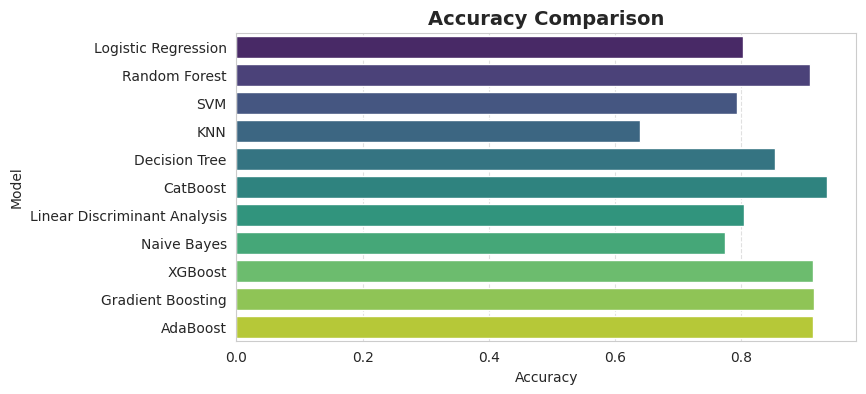

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


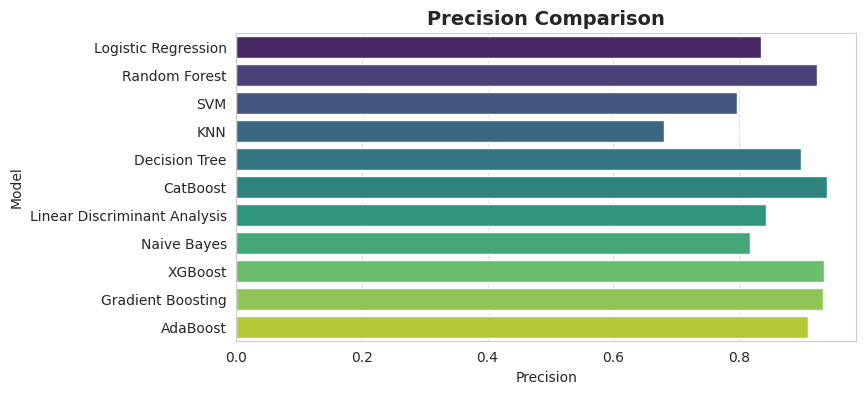

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


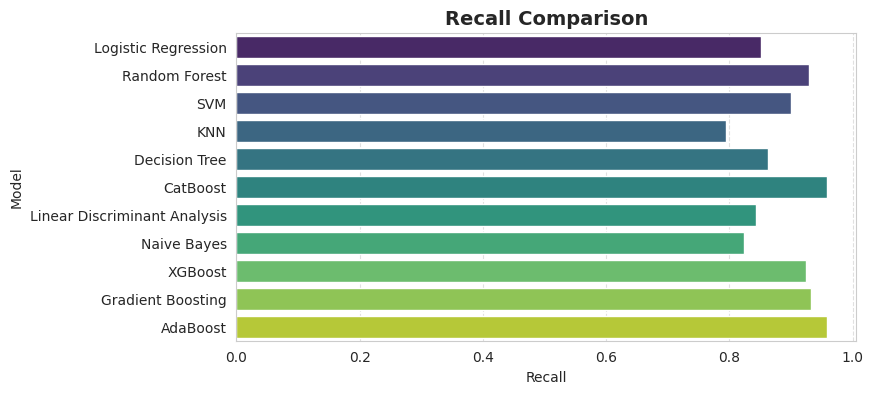

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


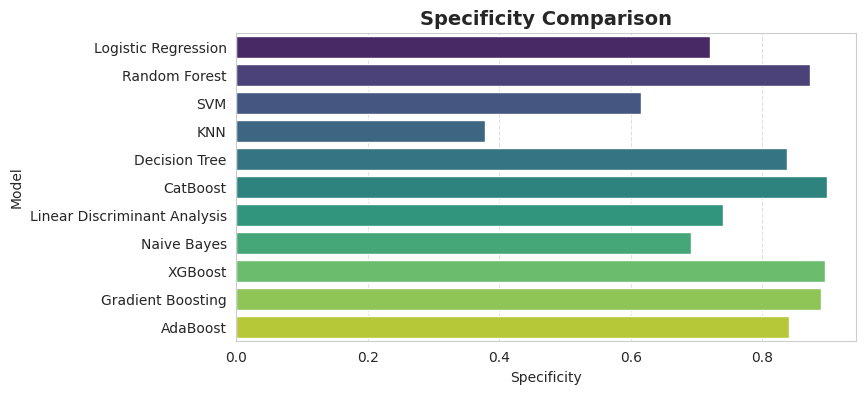

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


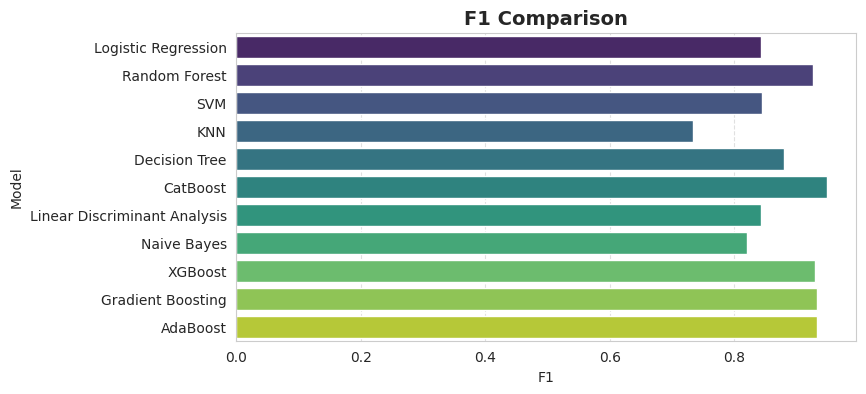

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


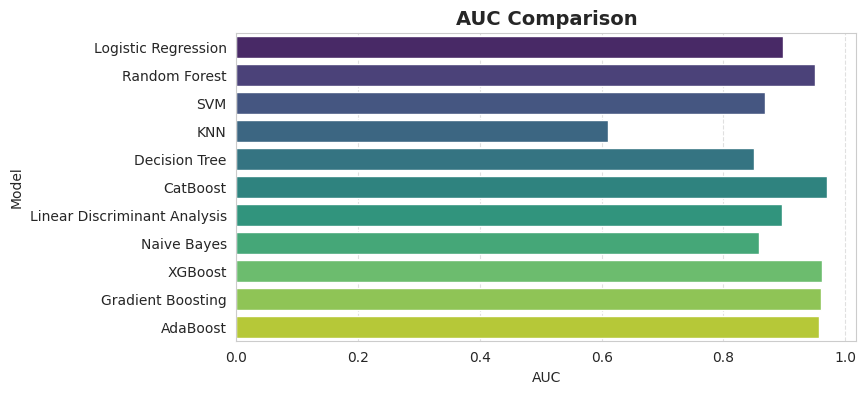

/tmp/ipython-input-617253851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)


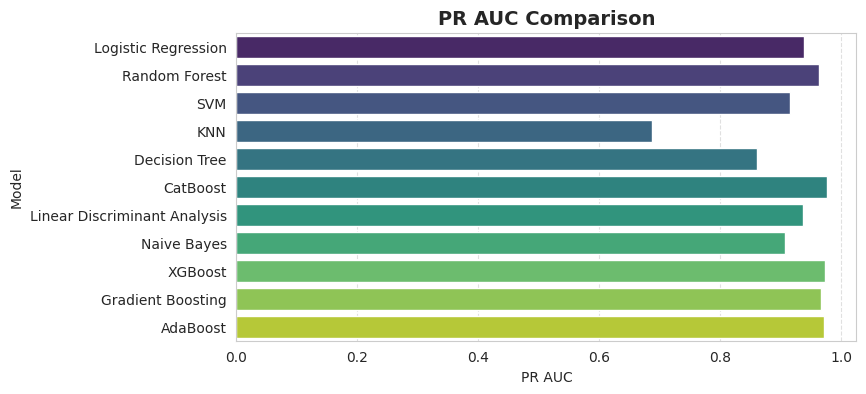

In [145]:
def plot_bar(metric_name, color='viridis'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=metrics_df_1[metric_name], y=metrics_df_1.index, palette=color)
    plt.title(f"{metric_name} Comparison", fontsize=14, fontweight='bold')
    plt.xlabel(metric_name)
    plt.ylabel("Model")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

for metric in ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC", "PR AUC"]:
    plot_bar(metric)

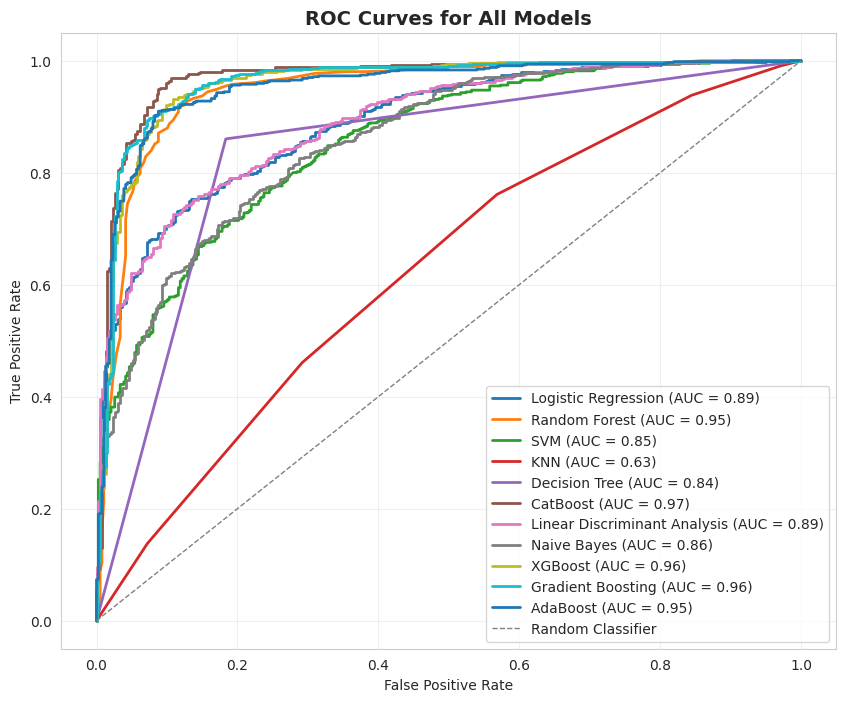

In [146]:
plt.figure(figsize=(10, 8))
for name, y_proba in y_proba_dict_2.items():
    if y_proba is not None:  # Only plot for successful models
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.title('ROC Curves for All Models', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

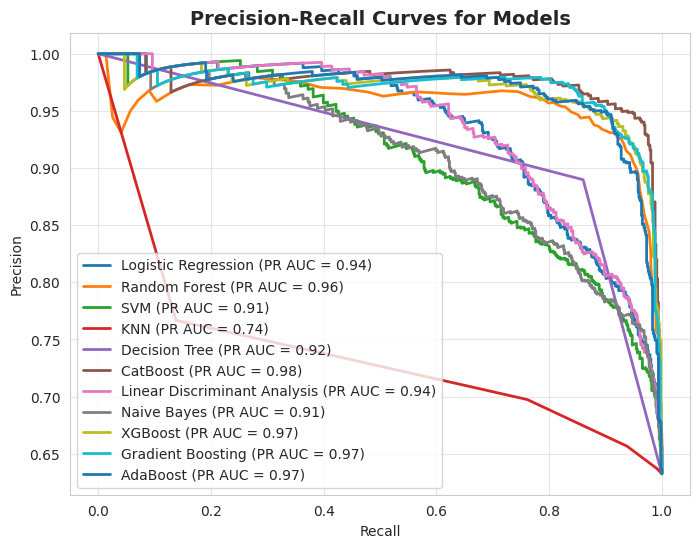

In [147]:
plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict_2.items():
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'{name} (PR AUC = {pr_auc:.2f})')

plt.title('Precision-Recall Curves for Models', fontsize=14, fontweight='bold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.show()

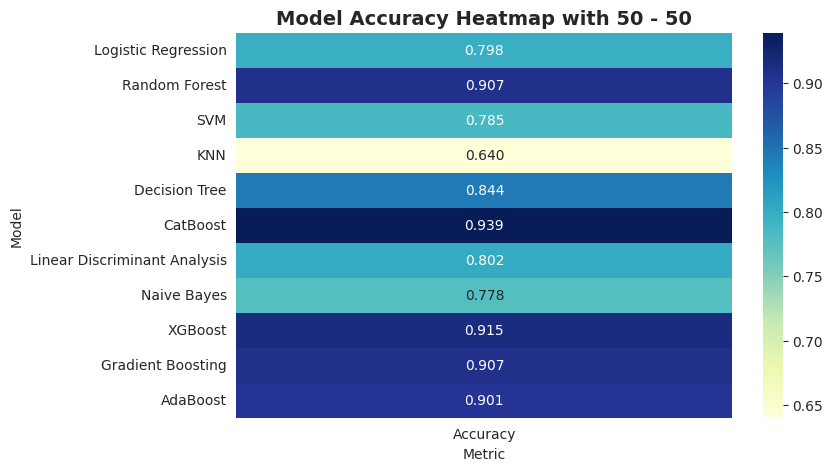

In [148]:
plt.figure(figsize=(8, 5))
sns.heatmap(metrics_df_2[["Accuracy"]], annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
plt.title("Model Accuracy Heatmap with 50 - 50", fontsize=14, fontweight="bold")
plt.xlabel("Metric")
plt.ylabel("Model")
plt.show()

# hyperparameter tunign with best model

In [152]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Define search space
search_spaces = {
    'iterations': Integer(100, 1000),
    'depth': Integer(4, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'border_count': Integer(32, 256),
    'random_strength': Real(0.1, 1.0)
}

catboost = CatBoostClassifier(verbose=0, random_state=42)

bayes_search = BayesSearchCV(
    estimator=catboost,
    search_spaces=search_spaces,
    n_iter=30,  # Number of iterations
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting Bayesian Optimization for CatBoost...")
bayes_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(bayes_search.best_params_)
print(f"\nBest cross-validation score: {bayes_search.best_score_:.4f}")

Starting Bayesian Optimization for CatBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

In [151]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00


Tuned CatBoost Feature Importance Analysis


/tmp/ipython-input-1732404721.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


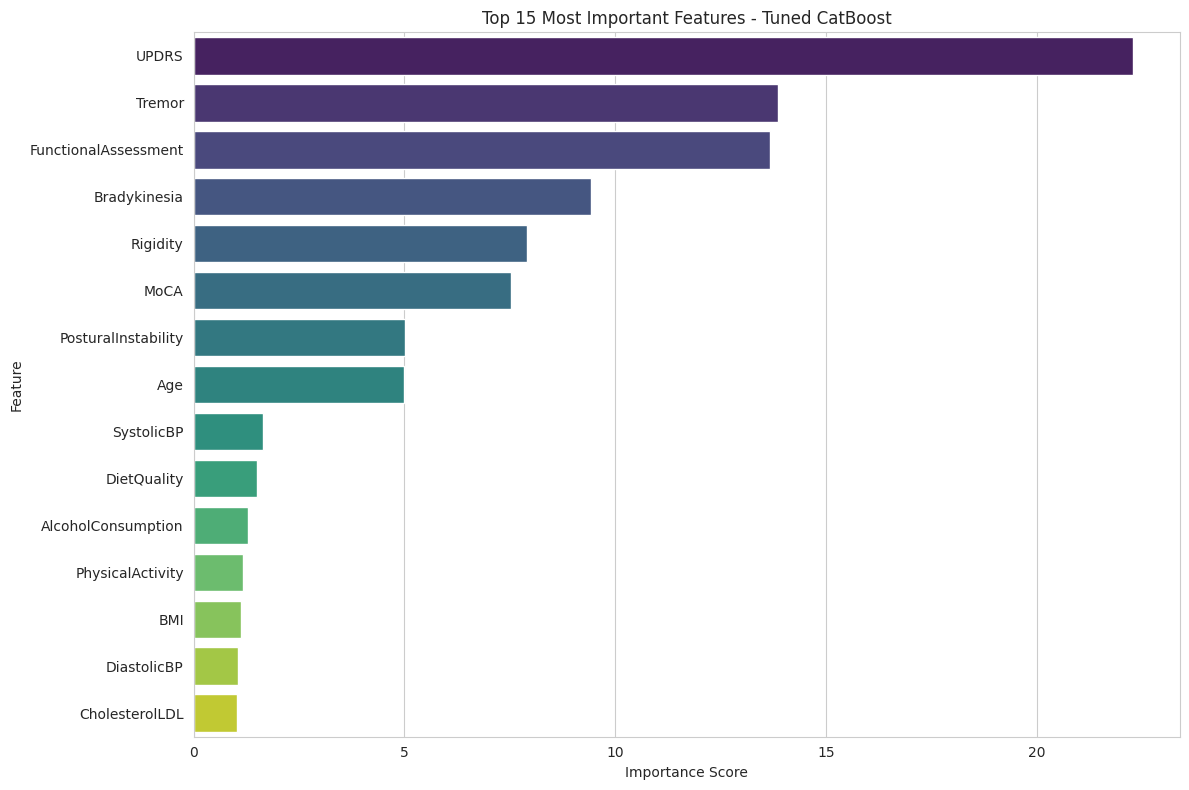


Feature Importance Summary:
Total number of features: 32
Top 5 features: ['UPDRS', 'Tremor', 'FunctionalAssessment', 'Bradykinesia', 'Rigidity']

Detailed Feature Importance:
                     Feature  Importance
22                     UPDRS     22.2895
25                    Tremor     13.8699
24      FunctionalAssessment     13.6658
27              Bradykinesia      9.4355
26                  Rigidity      7.9182
23                      MoCA      7.5288
28       PosturalInstability      5.0117
0                        Age      4.9892
16                SystolicBP      1.6490
8                DietQuality      1.4951
6         AlcoholConsumption      1.2957
7           PhysicalActivity      1.1658
4                        BMI      1.1248
17               DiastolicBP      1.0625
19            CholesterolLDL      1.0371
21  CholesterolTriglycerides      1.0301
18          CholesterolTotal      0.9328
14                Depression      0.9294
20            CholesterolHDL      0.8533
30  

In [157]:
best_catboost = bayes_search.best_estimator_

feature_importance = best_catboost.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Important Features - Tuned CatBoost')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nFeature Importance Summary:")
print(f"Total number of features: {len(importance_df)}")
print(f"Top 5 features: {list(importance_df['Feature'].head(5))}")

print("\nDetailed Feature Importance:")
print(importance_df.round(4))

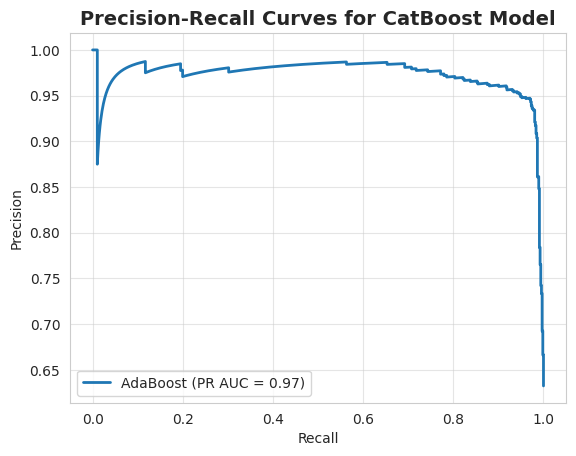

In [158]:
y_pred_tuned = best_catboost.predict(X_test)
y_proba_tuned = best_catboost.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba_tuned)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, lw=2, label=f'{name} (PR AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curves for CatBoost Model', fontsize=14, fontweight='bold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.show()

Generating Learning Curves...
Using best parameters: OrderedDict({'border_count': 186, 'depth': 7, 'iterations': 335, 'l2_leaf_reg': 5.443346797890038, 'learning_rate': 0.04241548285567903, 'random_strength': 0.24515732210438046})


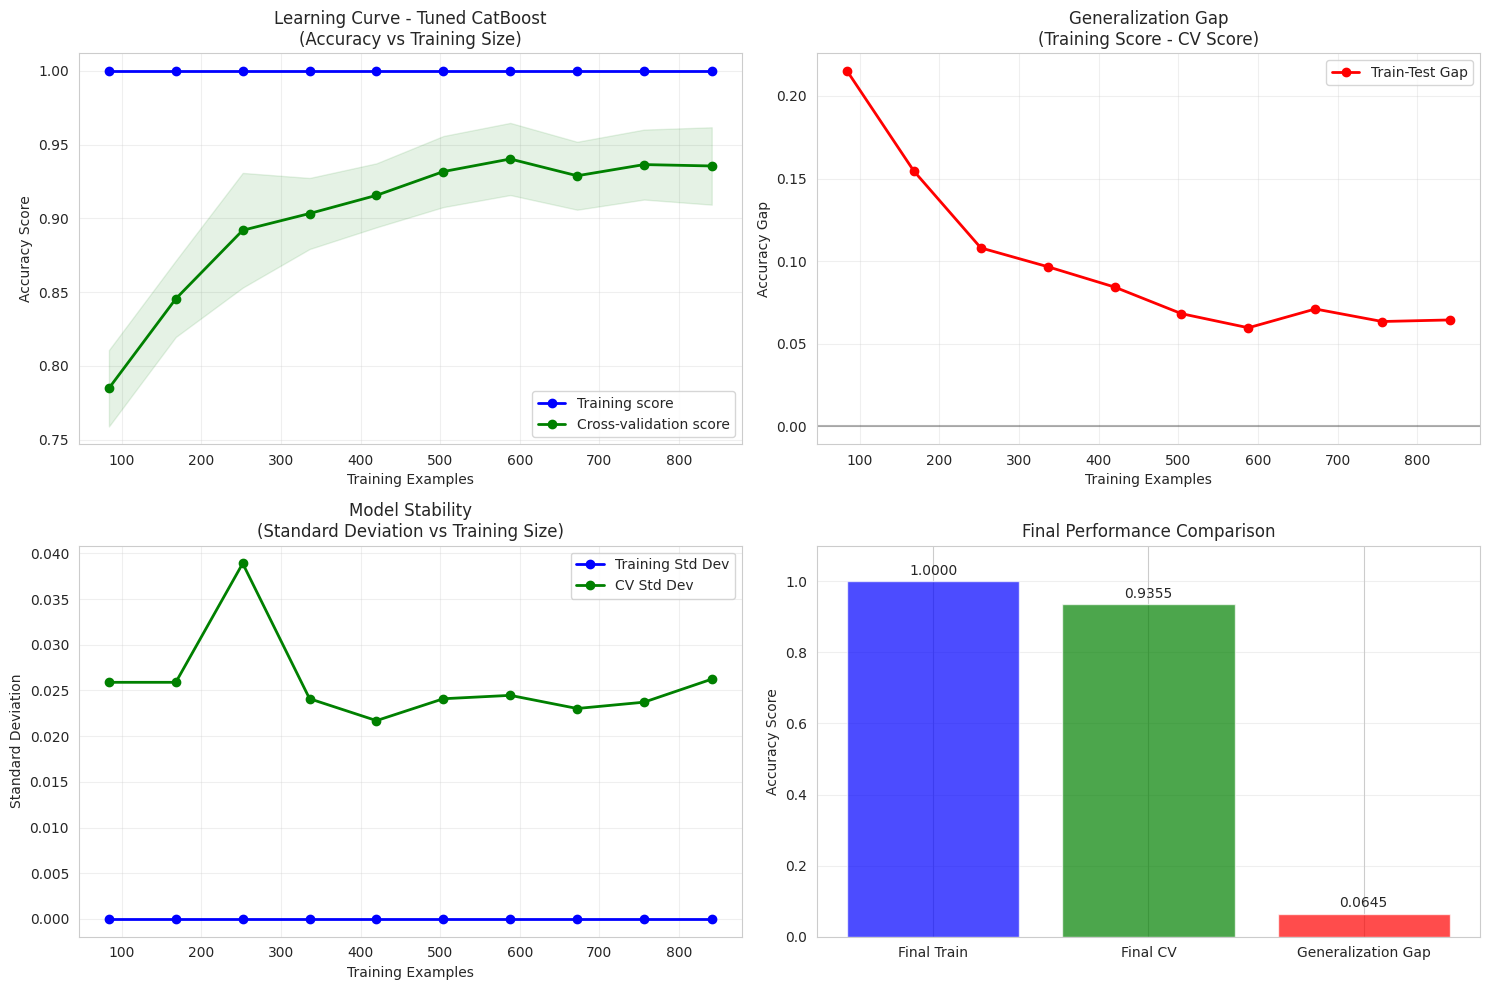


LEARNING CURVE ANALYSIS

Training sizes analyzed: [ 84 168 252 336 420 504 588 672 756 841]

Final Training Score: 1.0000
Final Cross-Validation Score: 0.9355
Generalization Gap: 0.0645

MODERATE GAP: Model shows some overfitting
LEARNING PROGRESS: Model improved by 0.1507 with more data
   - More data would likely help


In [161]:
from sklearn.model_selection import learning_curve, ShuffleSplit

best_params = bayes_search.best_params_
tuned_catboost = CatBoostClassifier(**best_params, verbose=0, random_state=42)

print("Generating Learning Curves...")
print(f"Using best parameters: {best_params}")


train_sizes = np.linspace(0.1, 1.0, 10)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


train_sizes, train_scores, test_scores = learning_curve(
    estimator=tuned_catboost,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score', linewidth=2)
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score', linewidth=2)

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1, color='green')

plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve - Tuned CatBoost\n(Accuracy vs Training Size)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)


plt.subplot(2, 2, 2)
gap = train_scores_mean - test_scores_mean
plt.plot(train_sizes, gap, 'o-', color='red', linewidth=2, label='Train-Test Gap')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Gap')
plt.title('Generalization Gap\n(Training Score - CV Score)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(train_sizes, train_scores_std, 'o-', color='blue', label='Training Std Dev', linewidth=2)
plt.plot(train_sizes, test_scores_std, 'o-', color='green', label='CV Std Dev', linewidth=2)
plt.xlabel('Training Examples')
plt.ylabel('Standard Deviation')
plt.title('Model Stability\n(Standard Deviation vs Training Size)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
final_train_score = train_scores_mean[-1]
final_test_score = test_scores_mean[-1]
gap_score = final_train_score - final_test_score

metrics = ['Final Train', 'Final CV', 'Generalization Gap']
scores = [final_train_score, final_test_score, gap_score]
colors = ['blue', 'green', 'red']

bars = plt.bar(metrics, scores, color=colors, alpha=0.7)
plt.ylabel('Accuracy Score')
plt.title('Final Performance Comparison')
plt.ylim(0, max(scores) * 1.1)

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*60)
print("LEARNING CURVE ANALYSIS")
print("="*60)

print(f"\nTraining sizes analyzed: {train_sizes.astype(int)}")
print(f"\nFinal Training Score: {final_train_score:.4f}")
print(f"Final Cross-Validation Score: {final_test_score:.4f}")
print(f"Generalization Gap: {gap_score:.4f}")

# Analyze learning curve patterns
if gap_score > 0.1:
    print("\nHIGH VARIANCE DETECTED: Model is overfitting")
    print("   - Consider: Regularization, Simplify model, Get more data")
elif gap_score < 0.02:
    print("\nGOOD GENERALIZATION: Model is well-balanced")
else:
    print("\nMODERATE GAP: Model shows some overfitting")

if test_scores_mean[-1] > test_scores_mean[0] + 0.05:
    improvement = test_scores_mean[-1] - test_scores_mean[0]
    print(f"LEARNING PROGRESS: Model improved by {improvement:.4f} with more data")
    print("   - More data would likely help")
else:
    print(" STABLE PERFORMANCE: Model performance plateaued")
    print("   - Focus on feature engineering or model architecture")